import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy import optimize

In [2]:
start_date =datetime.datetime(2002,1,1)
end_date = datetime.datetime(2023,12,30)
def get_stock_price(ticker):
    prices = yf.download(ticker,start_date,end_date)
    prices = prices["Adj Close"].dropna(how="all") 
    return prices

In [3]:
ticker_list = ['PG','KO','MSFT','JPM']
portfolio = get_stock_price(ticker_list)

[*********************100%%**********************]  4 of 4 completed


In [4]:
portfolio.to_csv("portfolio.csv",index=True)
portfolio = pd.read_csv("portfolio.csv",parse_dates=True,index_col="Date")

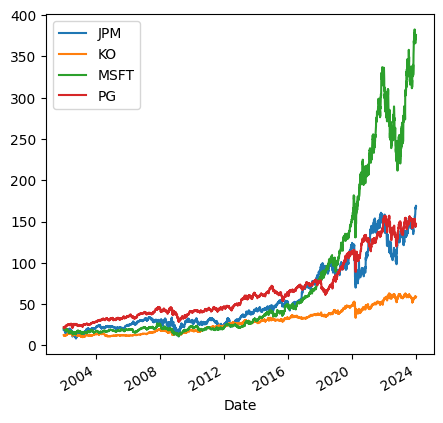

In [5]:
portfolio[portfolio.index >= "2002-01-01"].plot(figsize=(5,5));
plt.savefig('my_portfolio_plot.png')

In [6]:
portfolio.describe().T

count       mean        std        min        25%        50%  \
JPM   5537.0  55.901104  41.062848   8.445026  25.343441  33.955952   
KO    5537.0  28.781098  14.979023   9.998870  14.416759  26.976171   
MSFT  5537.0  76.606443  93.018987  11.304626  19.065586  25.090044   
PG    5537.0  65.347358  37.577726  21.006876  37.782009  50.830734   

            75%         max  
JPM   88.389000  169.256317  
KO    38.137005   62.817848  
MSFT  95.281387  382.700012  
PG    76.907043  157.220612

In [7]:
portfolio.dropna()

JPM         KO        MSFT          PG
Date                                                     
2002-01-02   19.129133  12.597630   20.781187   22.084211
2002-01-03   19.639597  12.433097   21.460045   21.871655
2002-01-04   20.523693  12.321631   21.357754   21.656321
2002-01-07   20.471075  12.000525   21.252354   21.407881
2002-01-08   20.313196  11.849257   21.506548   21.465851
...                ...        ...         ...         ...
2023-12-22  166.374069  58.320000  374.579987  145.279999
2023-12-26  167.358017  58.560001  374.660004  145.940002
2023-12-27  168.361816  58.709999  374.070007  146.059998
2023-12-28  169.256317  58.750000  375.279999  145.729996
2023-12-29  169.057541  58.930000  376.040009  146.539993

[5537 rows x 4 columns]

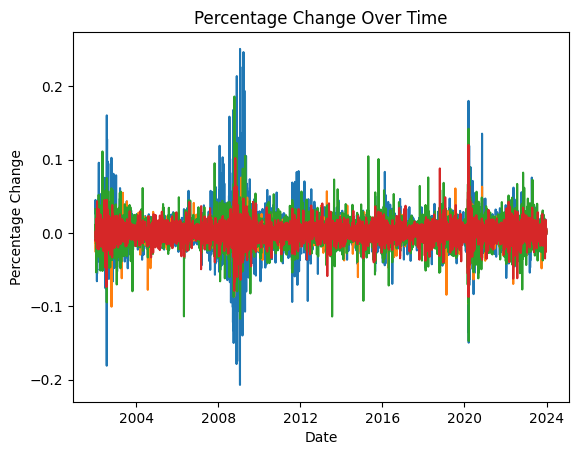

In [8]:
return_portfolio = portfolio.pct_change()
plt.plot(return_portfolio.index, return_portfolio.values, label='Percentage Change')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change Over Time')
plt.show()

In [9]:
np.random.seed(100)
# Weight each security
weights = np.random.random((4,1))
# normalize it
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(portfolio / portfolio.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [0.25986956 0.13312306 0.20301472 0.40399265]

Expected return of the portfolio is : 0.09668677287344092

Volatility of the portfolio: 0.19456488328457888

Sharpe ratio of the portfolio: 0.49693845693635647


In [10]:
# number of simulation
n = 10000


port_weights = np.zeros(shape=(n,len(portfolio.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(portfolio.columns)

for i in range(n):
    # Weight each security
    weights = np.random.random(4)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
    #print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
    #print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret / exp_vol
    port_sr[i] = sr 
    #print(f'\nSharpe ratio : {sr[0][0]}')

In [11]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]
max_sr
benchmark_portfolio_stat = np.array([max_sr_ret, max_sr_vol, max_sr])

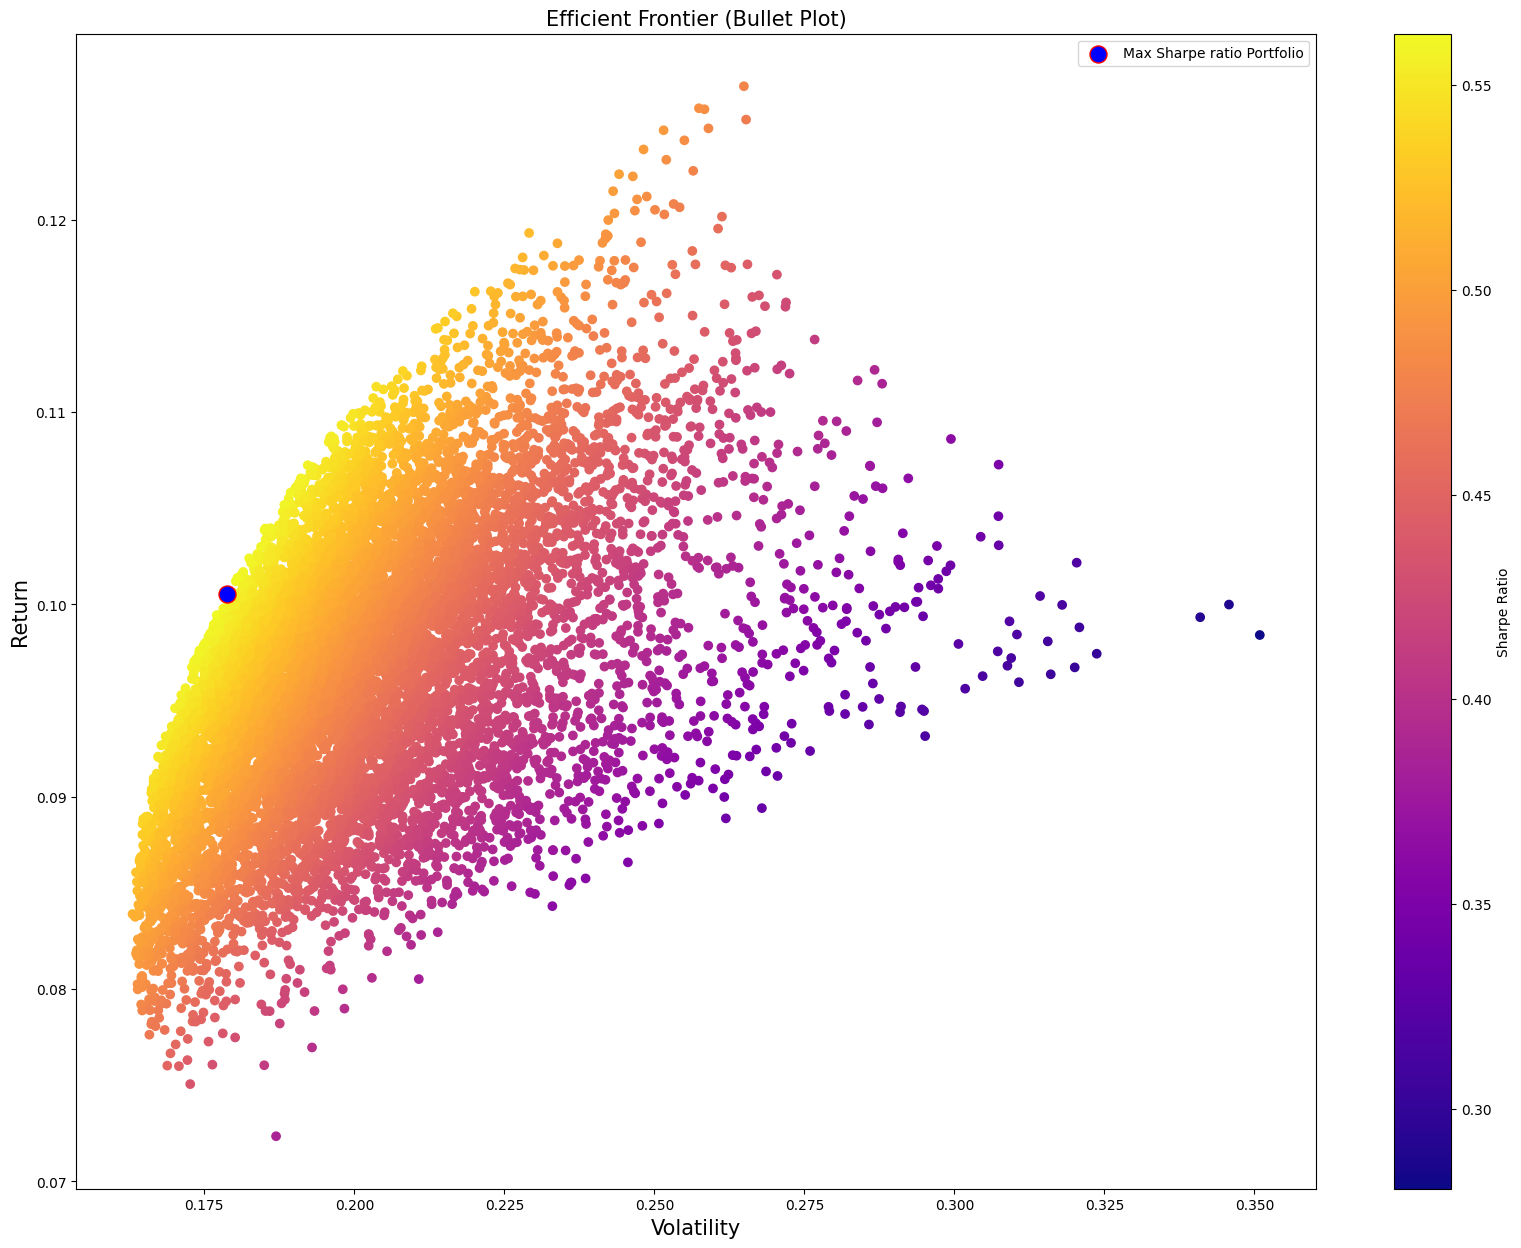

In [12]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();
plt.savefig('benchmark_efficient_frontier.png')

0.16 % of PG should be bought.
12.83 % of KO should be bought.
35.98 % of MSFT should be bought.
51.03 % of JPM should be bought.

Markowitz optimal portfolio return is : 10.06% with volatility \ 0.17875201227224444


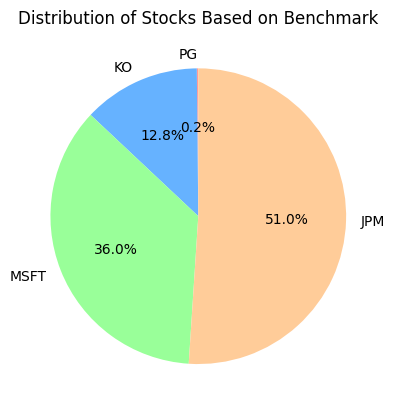

In [13]:
ticker_list = ['PG','KO','MSFT','JPM']
for weight, stocks in zip(port_weights[ind], ticker_list):
    print(f'{round(weight * 100, 2)} % of {stocks} should be bought.')
    
# best portfolio return
print(f'\nMarkowitz optimal portfolio return is : {round(max_sr_ret * 100, 2)}% with volatility \ {max_sr_vol}')
plt.pie(port_weights[ind], labels=ticker_list, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.title('Distribution of Stocks Based on Benchmark')
plt.savefig('markovitz_dist.png')

In [14]:
log_mean = log_ret.mean() * 252
cov = log_ret.cov() * 252
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = log_mean.dot(weights)
    vol = np.sqrt(weights.T.dot(cov.dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

# Negate Sharpe ratio as we need to max it but Scipy minimize the given function
def neg_sr(weights):
    return get_ret_vol_sr(weights)[-1] * -1

# check sum of weights 
def check_sum(weights):
    return np.sum(weights) - 1
# Constraints for the optimization problem
cons = {'type':'eq','fun':check_sum}
# bounds on weights
bounds = ((0,1),(0,1),(0,1),(0,1))
# initial guess for optimization to start with
init_guess = [.25 for _ in range(4)]




In [15]:
# Call minimizer
opt_results = optimize.minimize(neg_sr, init_guess, constraints=cons, bounds=bounds, method='SLSQP')

In [16]:
optimal_weights = opt_results.x
# optimal_weights
for st, i in zip(ticker_list,optimal_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')

Stock PG has weight 0.0 %
Stock KO has weight 10.3 %
Stock MSFT has weight 35.87 %
Stock JPM has weight 53.82 %


In [17]:
mc_weights = port_weights[ind]
for st, i in zip(ticker_list,mc_weights):
    print(f'Stock {st} has weight {np.round(i*100,2)} %')

Stock PG has weight 0.16 %
Stock KO has weight 12.83 %
Stock MSFT has weight 35.98 %
Stock JPM has weight 51.03 %


In [18]:
daily_portfolio_value = np.log(portfolio).dot(port_weights[ind])
daily_portfolio_value

Date
2002-01-02    3.000737
2002-01-03    3.005724
2002-01-04    2.997870
2002-01-07    2.986811
2002-01-08    2.990829
                ...   
2023-12-22    5.202590
2023-12-26    5.205516
2023-12-27    5.205707
2023-12-28    5.205810
2023-12-29    5.209757
Length: 5537, dtype: float64

In [19]:
# Calculate daily returns
daily_returns = daily_portfolio_value.pct_change()
daily_returns

Date
2002-01-02         NaN
2002-01-03    0.001662
2002-01-04   -0.002613
2002-01-07   -0.003689
2002-01-08    0.001345
                ...   
2023-12-22    0.001024
2023-12-26    0.000562
2023-12-27    0.000037
2023-12-28    0.000020
2023-12-29    0.000758
Length: 5537, dtype: float64

In [20]:
# Calculate cumulative returns
cumulative_returns_benchmark = (1 + daily_returns).cumprod()
cumulative_returns_benchmark

Date
2002-01-02         NaN
2002-01-03    1.001662
2002-01-04    0.999045
2002-01-07    0.995359
2002-01-08    0.996698
                ...   
2023-12-22    1.733771
2023-12-26    1.734746
2023-12-27    1.734809
2023-12-28    1.734844
2023-12-29    1.736159
Length: 5537, dtype: float64

In [21]:
total_return = cumulative_returns_benchmark.iloc[-1] - 1
total_return

0.7361589313866259

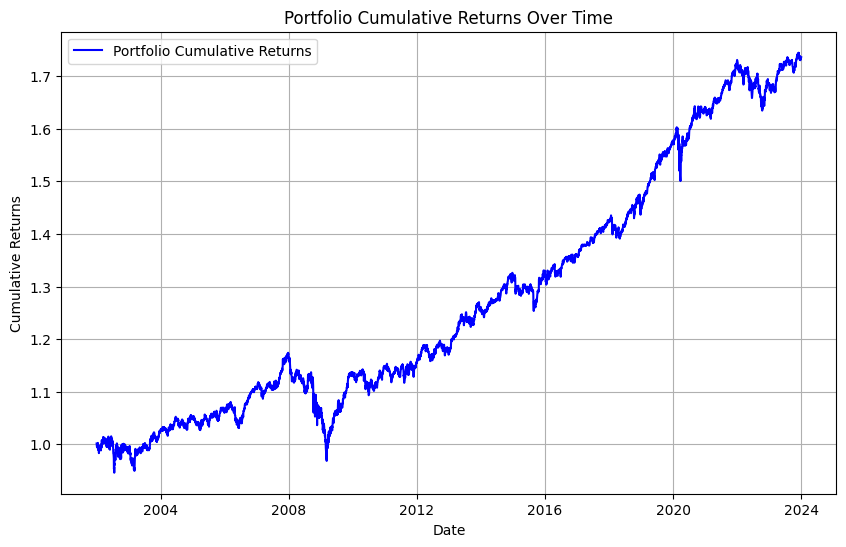

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_benchmark.index, cumulative_returns_benchmark, label='Portfolio Cumulative Returns', color='blue')
plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
jpm =portfolio["JPM"]
jpm = pd.DataFrame(jpm)
jpm

JPM
Date                  
2002-01-02   19.129133
2002-01-03   19.639597
2002-01-04   20.523693
2002-01-07   20.471075
2002-01-08   20.313196
...                ...
2023-12-22  166.374069
2023-12-26  167.358017
2023-12-27  168.361816
2023-12-28  169.256317
2023-12-29  169.057541

[5537 rows x 1 columns]

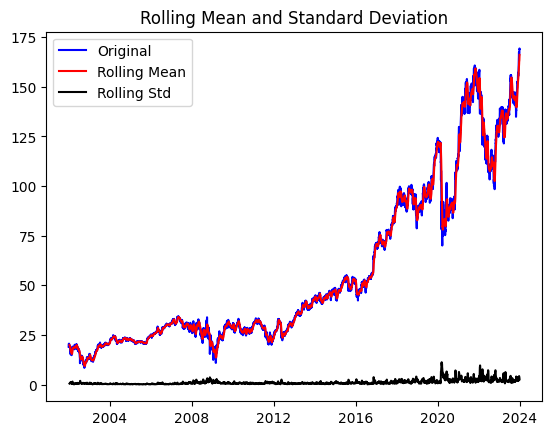

Results of dickey fuller test
Test Statistics                   0.614378
p-value                           0.987965
No. of lags used                 33.000000
Number of observations used    5503.000000
critical value (1%)              -3.431539
critical value (5%)              -2.862065
critical value (10%)             -2.567050
dtype: float64


In [24]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(jpm["JPM"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


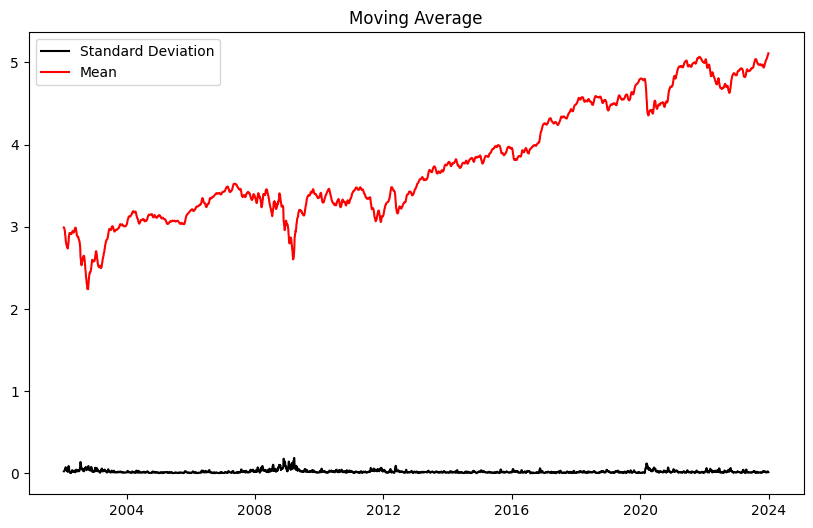

In [25]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(jpm["JPM"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Date
2020-09-11    4.515179
2020-09-14    4.528936
2020-09-15    4.497310
2020-09-16    4.501531
2020-09-17    4.490032
                ...   
2023-12-22    5.114239
2023-12-26    5.120135
2023-12-27    5.126115
2023-12-28    5.131414
2023-12-29    5.130239
Name: JPM, Length: 831, dtype: float64
Date
2002-01-07    3.019013
2002-01-08    3.011271
2002-01-09    3.014116
2002-01-10    3.025163
2002-01-11    3.004512
                ...   
2020-09-03    4.517748
2020-09-04    4.539131
2020-09-08    4.503736
2020-09-09    4.513198
2020-09-10    4.502835
Name: JPM, Length: 4703, dtype: float64


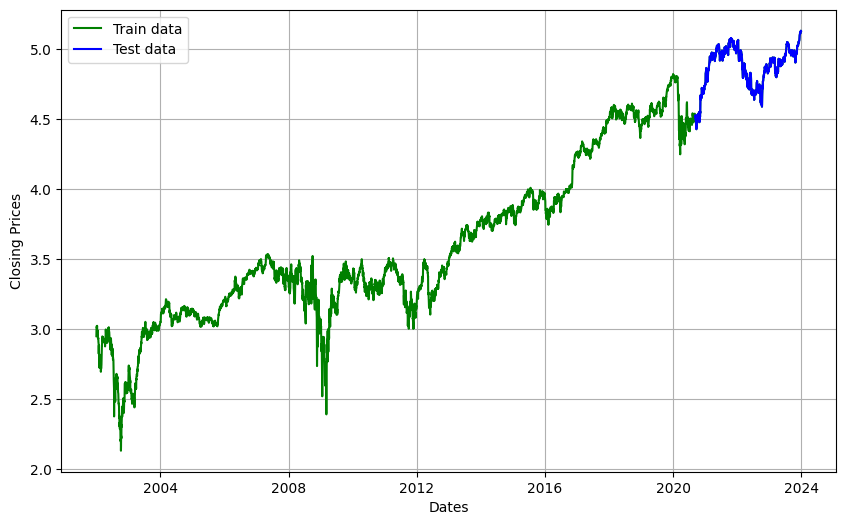

In [26]:
train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.savefig('train_test_jpm.png')
print(test_data)
print(train_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21602.084, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21652.426, Time=0.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21652.724, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21603.292, Time=0.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21650.653, Time=1.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-21650.690, Time=2.71 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-21655.546, Time=3.09 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-21654.196, Time=8.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-21660.451, Time=4.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-21654.821, Time=4.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-21658.043, Time=4.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-21663.058, Time=5.78 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-21663.836, Time=7.36 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-21664.262, Time=2.61 sec
 ARIM

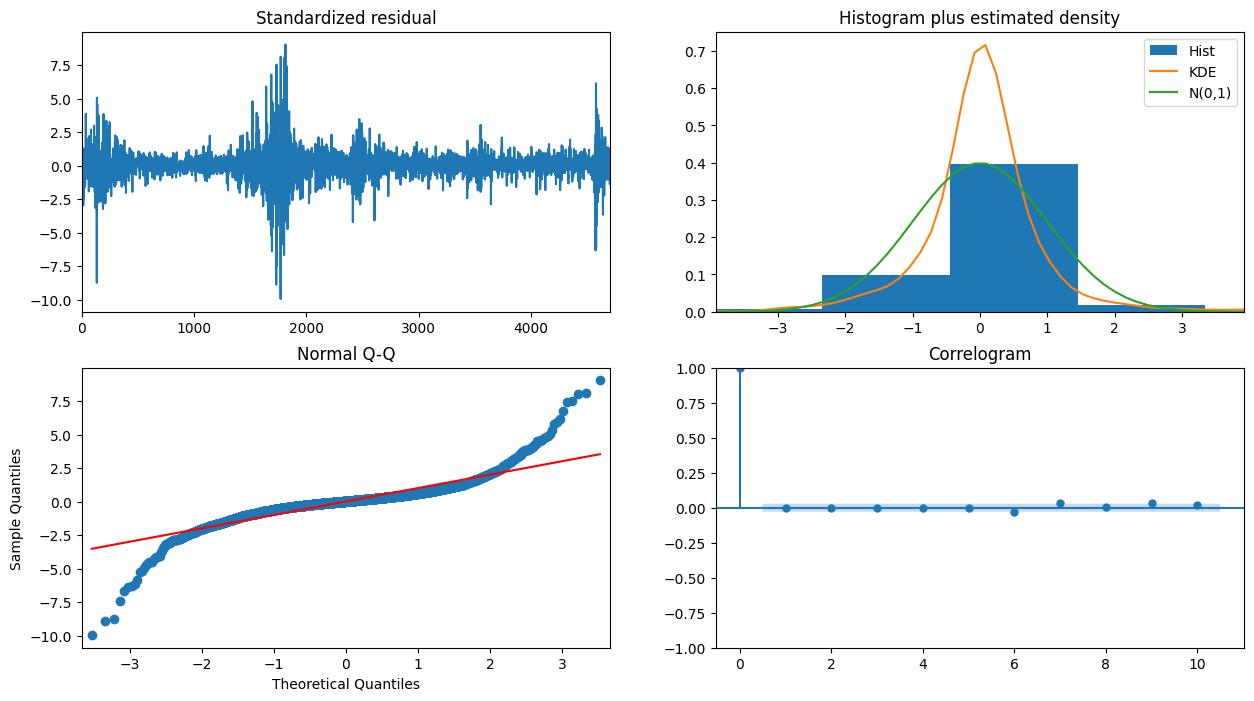

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [28]:
#Modelin
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(0,1,5), trend="t")
result = model.fit()
  
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                    JPM   No. Observations:                 4703
Model:                 ARIMA(0, 1, 5)   Log Likelihood               10839.131
Date:                Tue, 09 Jan 2024   AIC                         -21664.261
Time:                        13:47:01   BIC                         -21619.071
Sample:                             0   HQIC                        -21648.373
                               - 4703                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.000      1.069      0.285      -0.000       0.001
ma.L1         -0.1103      0.006    -19.581      0.000      -0.121      -0.099
ma.L2          0.0001      0.006      0.019      0.9

In [29]:
predicted = result.predict()
predicted = pd.DataFrame(predicted)

fc = result.forecast(831)
fc = pd.DataFrame(fc)
indeks = test_data.index
fc = fc.set_index(indeks)
predicted = predicted.iloc[1: , :]
predicted


predicted_mean
Date                      
2002-01-08        3.019325
2002-01-09        3.012441
2002-01-10        3.014220
2002-01-11        3.024476
2002-01-14        3.007295
...                    ...
2020-09-03        4.519138
2020-09-04        4.519217
2020-09-08        4.537474
2020-09-09        4.507178
2020-09-10        4.512042

[4702 rows x 1 columns]

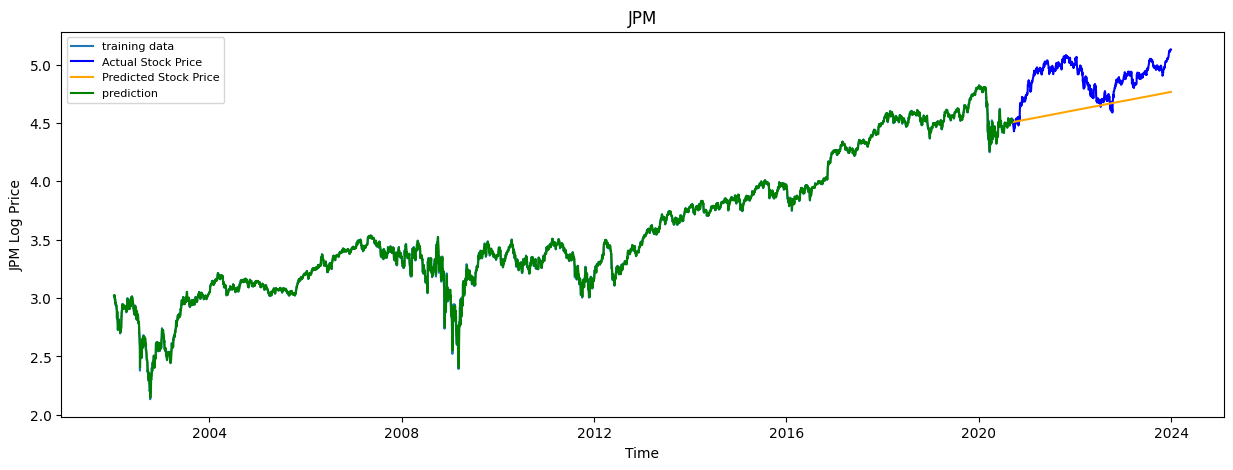

In [30]:
plt.figure(figsize=(15,5))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.plot(predicted, color ="green", label = "prediction")
plt.title('JPM')
plt.xlabel('Time')
plt.ylabel('JPM Log Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
import math
mse_jpm_arima = mean_squared_error(test_data, fc)
print('MSE: '+str(mse_jpm_arima))
rmse_jpm_arima = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse_jpm_arima))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.07778013972436604
RMSE: 0.27889091007841404
MAPE: nan


In [32]:
jpm_forecast = pd.concat([predicted, fc], axis=0)
jpm_forecast

predicted_mean
Date                      
2002-01-08        3.019325
2002-01-09        3.012441
2002-01-10        3.014220
2002-01-11        3.024476
2002-01-14        3.007295
...                    ...
2023-12-22        4.764365
2023-12-26        4.764677
2023-12-27        4.764989
2023-12-28        4.765302
2023-12-29        4.765614

[5533 rows x 1 columns]

In [33]:
ko =portfolio["KO"]
ko = pd.DataFrame(ko)
ko

KO
Date                 
2002-01-02  12.597630
2002-01-03  12.433097
2002-01-04  12.321631
2002-01-07  12.000525
2002-01-08  11.849257
...               ...
2023-12-22  58.320000
2023-12-26  58.560001
2023-12-27  58.709999
2023-12-28  58.750000
2023-12-29  58.930000

[5537 rows x 1 columns]

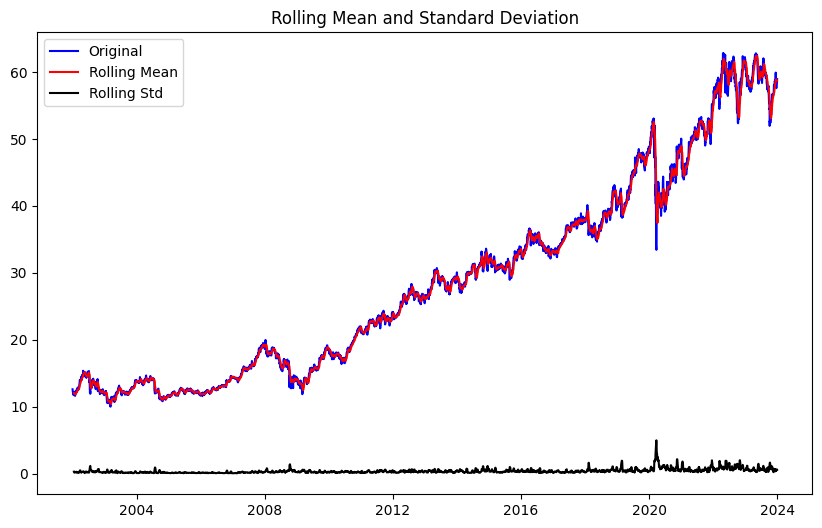

Results of dickey fuller test
Test Statistics                   0.235872
p-value                           0.974203
No. of lags used                 29.000000
Number of observations used    5507.000000
critical value (1%)              -3.431538
critical value (5%)              -2.862065
critical value (10%)             -2.567049
dtype: float64


In [34]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(ko["KO"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


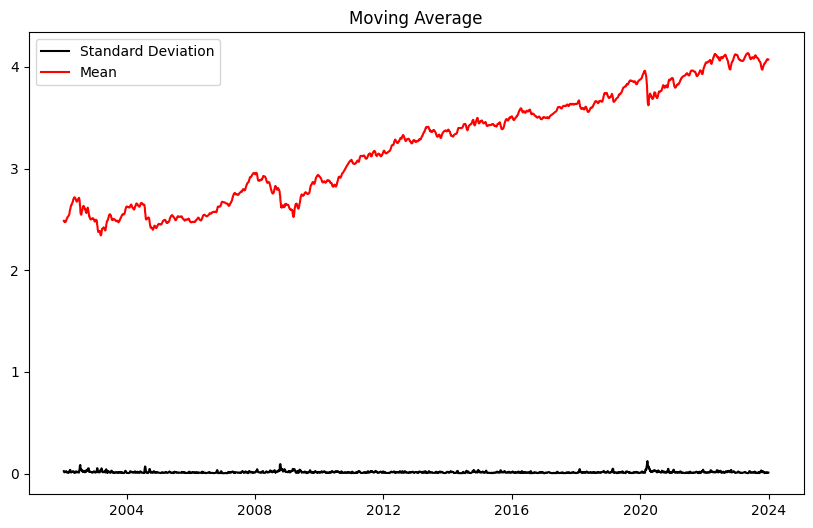

In [35]:
#not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(ko["KO"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Date
2020-09-11    3.825872
2020-09-14    3.827055
2020-09-15    3.833738
2020-09-16    3.828632
2020-09-17    3.823895
                ...   
2023-12-22    4.065945
2023-12-26    4.070052
2023-12-27    4.072610
2023-12-28    4.073291
2023-12-29    4.076350
Name: KO, Length: 831, dtype: float64


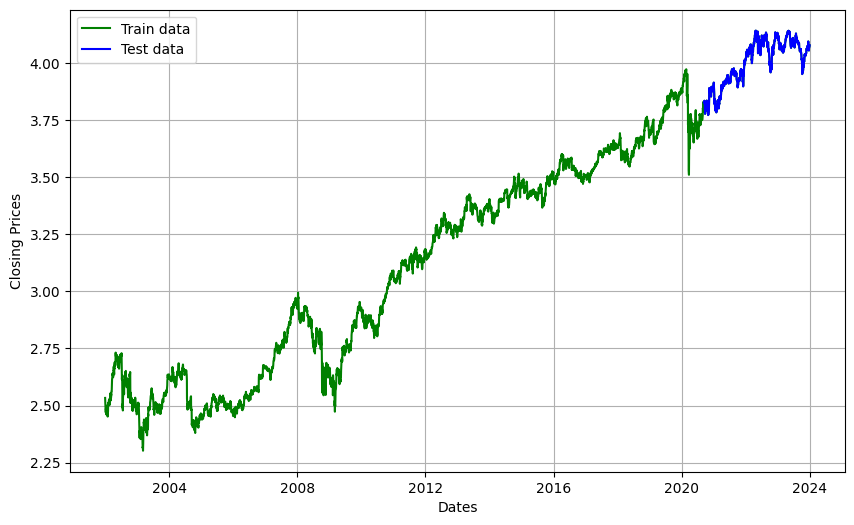

In [36]:
train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
print(test_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28121.755, Time=0.75 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28132.856, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28132.735, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28121.249, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28130.926, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28130.946, Time=2.00 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28128.900, Time=4.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-28132.069, Time=0.50 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 11.429 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4703
Model:               SARIMAX(1, 1, 0)   Log Likelihood               14069.428
Date:                Tue, 09 Jan 2024   AIC                         -28132.856
Time:              

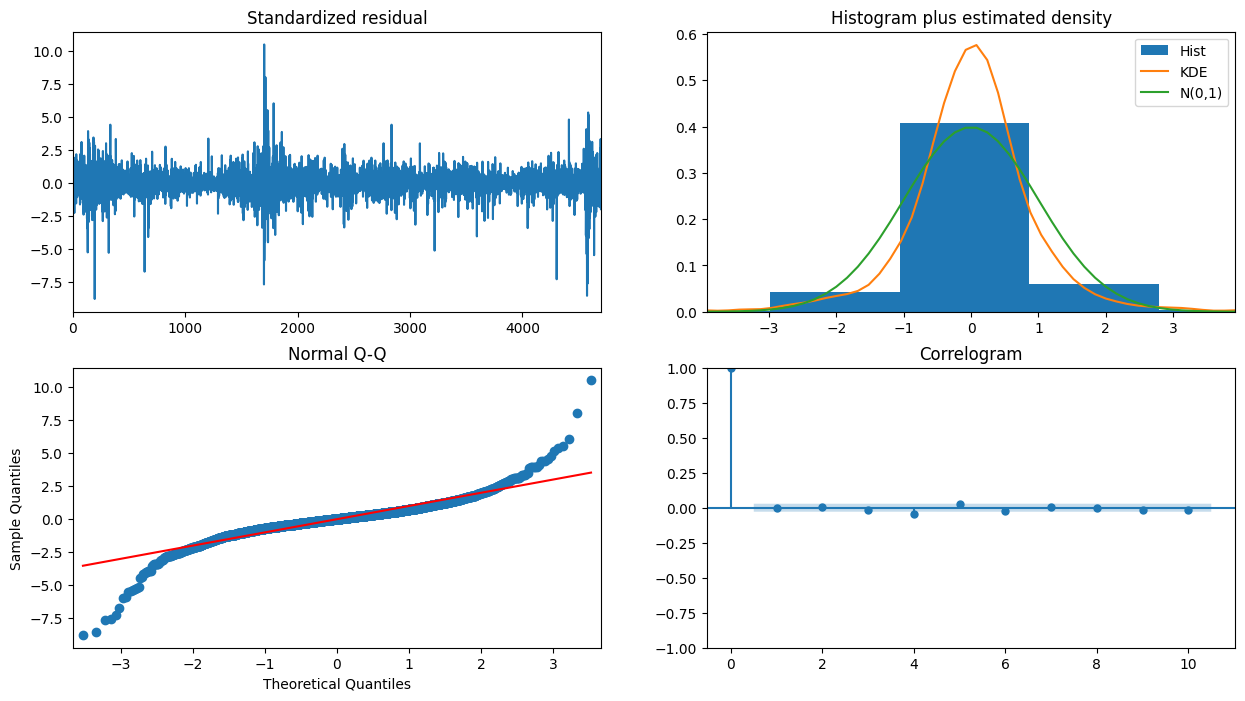

In [37]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [38]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(1,1,0), trend="t")
result = model.fit()
  
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                     KO   No. Observations:                 4703
Model:                 ARIMA(1, 1, 0)   Log Likelihood               14069.428
Date:                Tue, 09 Jan 2024   AIC                         -28132.856
Time:                        13:47:19   BIC                         -28113.489
Sample:                             0   HQIC                        -28126.047
                               - 4703                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.000      1.637      0.102   -5.54e-05       0.001
ar.L1         -0.0527      0.007     -7.457      0.000      -0.067      -0.039
sigma2         0.0001   1.17e-06    126.206      0.0

In [39]:
predicted = result.predict()
predicted = pd.DataFrame(predicted)

fc = result.forecast(831)
fc = pd.DataFrame(fc)
indeks = test_data.index
fc = fc.set_index(indeks)
predicted = predicted.iloc[1: , :]
predicted

predicted_mean
Date                      
2002-01-08        2.485231
2002-01-09        2.473230
2002-01-10        2.470650
2002-01-11        2.475208
2002-01-14        2.486404
...                    ...
2020-09-03        3.826532
2020-09-04        3.815479
2020-09-08        3.825193
2020-09-09        3.802668
2020-09-10        3.808580

[4702 rows x 1 columns]

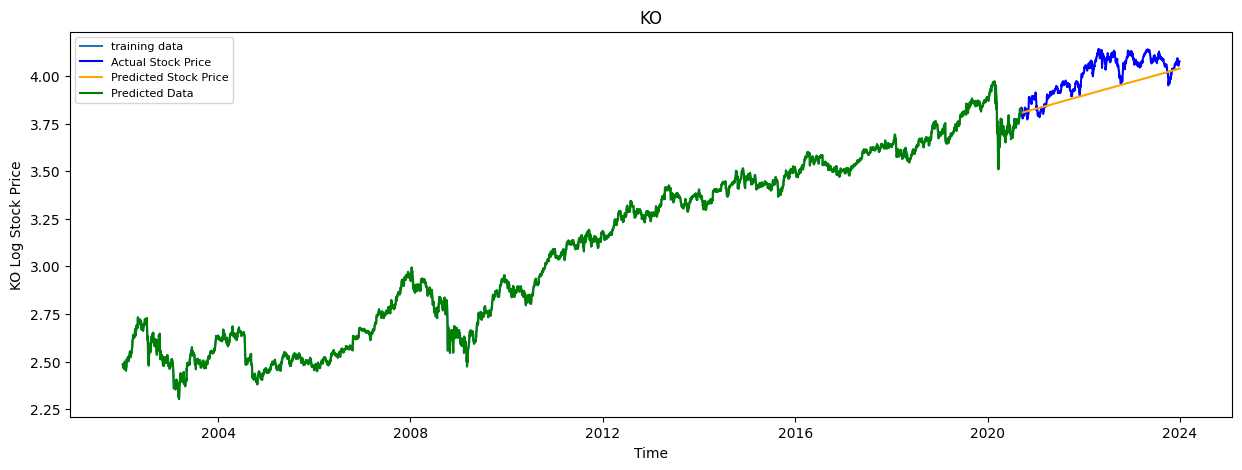

In [40]:
plt.figure(figsize=(15,5))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.plot(predicted, color = "green", label = "Predicted Data")
plt.title('KO')
plt.xlabel('Time')
plt.ylabel('KO Log Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [41]:
import math
mse_ko_arima = mean_squared_error(test_data, fc)
print('MSE: '+str(mse_ko_arima))
rmse_ko_arima = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse_ko_arima))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.010210543181256455
RMSE: 0.10104723242749628
MAPE: nan


In [42]:
ko_forecast = pd.concat([predicted, fc], axis=0)
ko_forecast

predicted_mean
Date                      
2002-01-08        2.485231
2002-01-09        2.473230
2002-01-10        2.470650
2002-01-11        2.475208
2002-01-14        2.486404
...                    ...
2023-12-22        4.037252
2023-12-26        4.037533
2023-12-27        4.037814
2023-12-28        4.038094
2023-12-29        4.038375

[5533 rows x 1 columns]

In [43]:
msft =portfolio["MSFT"]
msft = pd.DataFrame(msft)
msft

MSFT
Date                  
2002-01-02   20.781187
2002-01-03   21.460045
2002-01-04   21.357754
2002-01-07   21.252354
2002-01-08   21.506548
...                ...
2023-12-22  374.579987
2023-12-26  374.660004
2023-12-27  374.070007
2023-12-28  375.279999
2023-12-29  376.040009

[5537 rows x 1 columns]

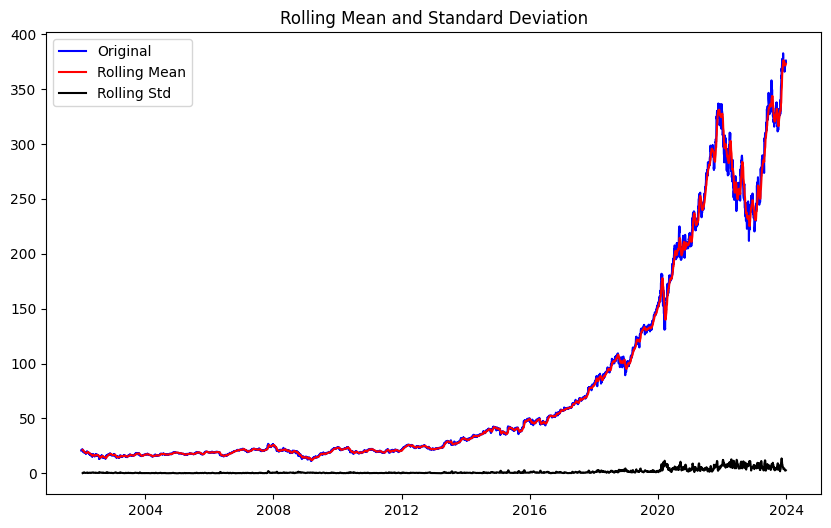

Results of dickey fuller test
Test Statistics                   3.331443
p-value                           1.000000
No. of lags used                 32.000000
Number of observations used    5504.000000
critical value (1%)              -3.431539
critical value (5%)              -2.862065
critical value (10%)             -2.567050
dtype: float64


In [44]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(msft["MSFT"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


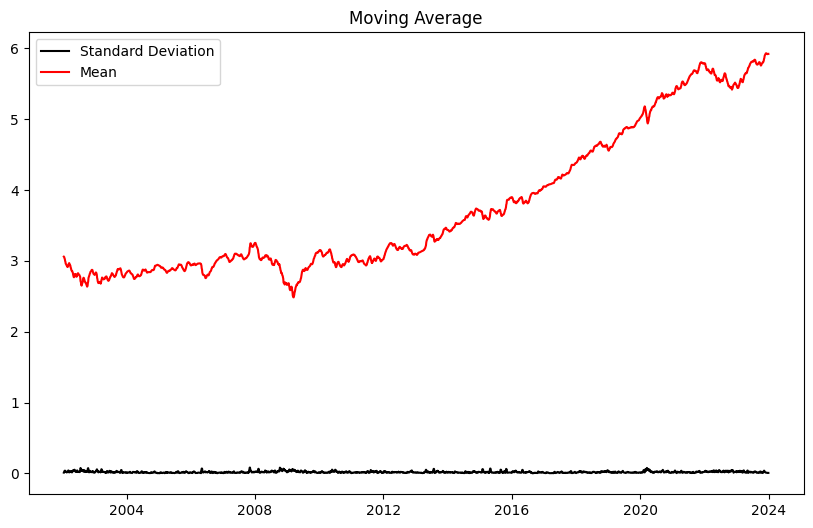

In [45]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(msft["MSFT"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Date
2020-09-11    5.289151
2020-09-14    5.295892
2020-09-15    5.312165
2020-09-16    5.294137
2020-09-17    5.283646
                ...   
2023-12-22    5.925805
2023-12-26    5.926019
2023-12-27    5.924443
2023-12-28    5.927672
2023-12-29    5.929696
Name: MSFT, Length: 831, dtype: float64
Date
2002-01-07    3.056468
2002-01-08    3.068357
2002-01-09    3.058653
2002-01-10    3.066915
2002-01-11    3.057197
                ...   
2020-09-03    5.352163
2020-09-04    5.338027
2020-09-08    5.282413
2020-09-09    5.324115
2020-09-10    5.295697
Name: MSFT, Length: 4703, dtype: float64


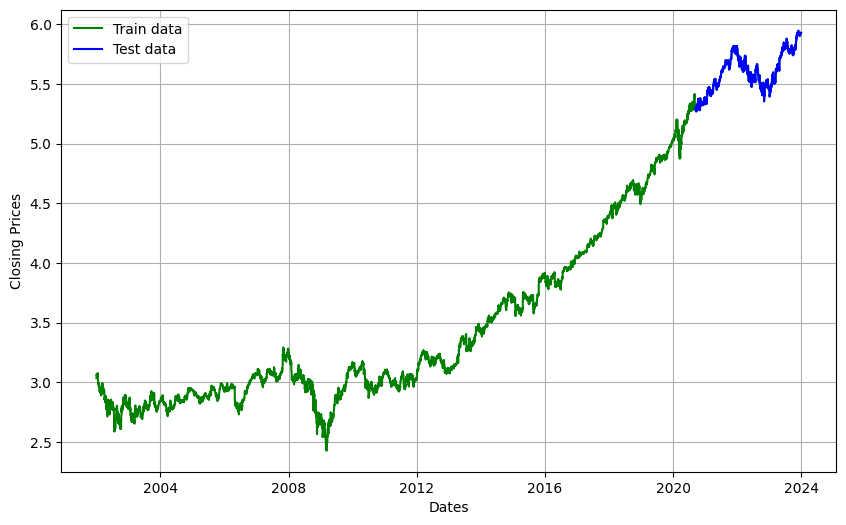

In [46]:
train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
print(test_data)
print(train_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24603.519, Time=1.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24676.494, Time=0.52 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24679.157, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24602.107, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24677.392, Time=2.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-24677.415, Time=2.64 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-24676.282, Time=2.15 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-24676.575, Time=0.82 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 13.113 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4703
Model:               SARIMAX(0, 1, 1)   Log Likelihood               12342.579
Date:                Tue, 09 Jan 2024   AIC                         -24679.157
Time:              

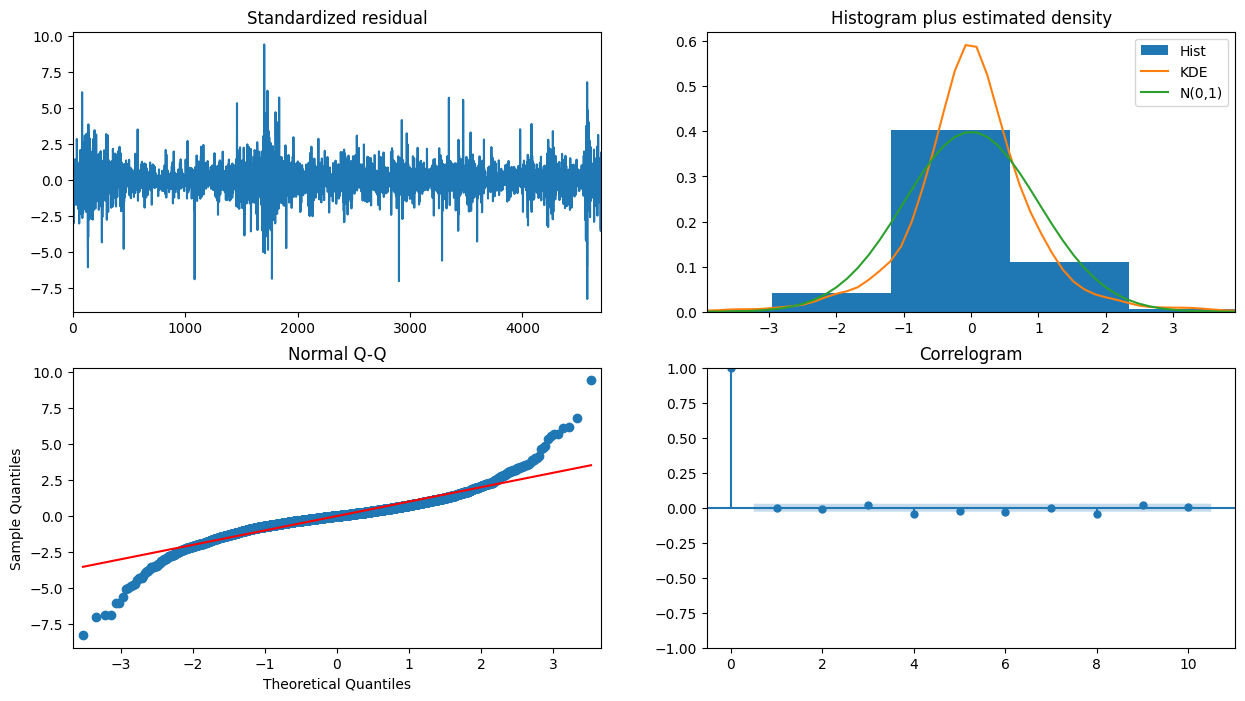

In [47]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [48]:
import statsmodels.api as sm

model = sm.tsa.arima.ARIMA(train_data, order=(0,1,1), trend="t")
result = model.fit()
  
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                   MSFT   No. Observations:                 4703
Model:                 ARIMA(0, 1, 1)   Log Likelihood               12342.578
Date:                Tue, 09 Jan 2024   AIC                         -24679.157
Time:                        13:47:38   BIC                         -24659.790
Sample:                             0   HQIC                        -24672.348
                               - 4703                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0005      0.000      2.111      0.035    3.38e-05       0.001
ma.L1         -0.1286      0.008    -15.584      0.000      -0.145      -0.112
sigma2         0.0003   2.85e-06    107.621      0.0

In [49]:
predicted = result.predict()
predicted = pd.DataFrame(predicted)

fc = result.forecast(831)
fc = pd.DataFrame(fc)
indeks = test_data.index
fc = fc.set_index(indeks)
predicted = predicted.iloc[1: , :]
predicted

predicted_mean
Date                      
2002-01-08        3.056941
2002-01-09        3.067387
2002-01-10        3.060249
2002-01-11        3.066531
2002-01-14        3.058871
...                    ...
2020-09-03        5.414100
2020-09-04        5.360601
2020-09-08        5.341403
2020-09-09        5.290472
2020-09-10        5.320262

[4702 rows x 1 columns]

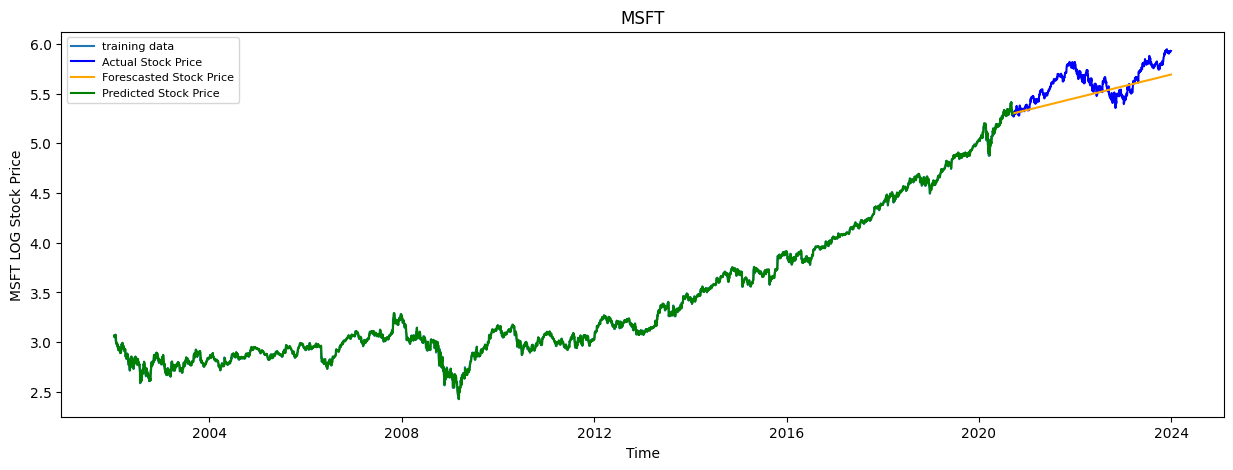

In [50]:
plt.figure(figsize=(15,5))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Forescasted Stock Price')
plt.plot(predicted, color="green", label ="Predicted Stock Price")
plt.title('MSFT')
plt.xlabel('Time')
plt.ylabel('MSFT LOG Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('msft_arima_prediction.png')
plt.show()


In [51]:
mse_msft_arıma = mean_squared_error(test_data, fc)
print('MSE: '+str(mse_msft_arıma))
rmse_msft_arıma = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse_msft_arıma))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.02706877159364179
RMSE: 0.16452589946157958
MAPE: nan


In [52]:
msft_forecast = pd.concat([predicted, fc], axis=0)
msft_forecast

predicted_mean
Date                      
2002-01-08        3.056941
2002-01-09        3.067387
2002-01-10        3.060249
2002-01-11        3.066531
2002-01-14        3.058871
...                    ...
2023-12-22        5.690284
2023-12-26        5.690758
2023-12-27        5.691231
2023-12-28        5.691704
2023-12-29        5.692178

[5533 rows x 1 columns]

In [53]:
pg =portfolio["PG"]
pg = pd.DataFrame(pg)
pg

PG
Date                  
2002-01-02   22.084211
2002-01-03   21.871655
2002-01-04   21.656321
2002-01-07   21.407881
2002-01-08   21.465851
...                ...
2023-12-22  145.279999
2023-12-26  145.940002
2023-12-27  146.059998
2023-12-28  145.729996
2023-12-29  146.539993

[5537 rows x 1 columns]

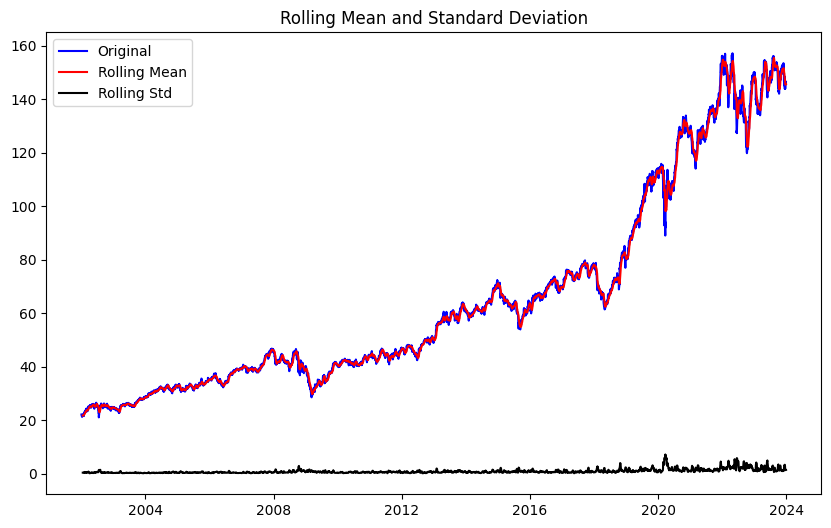

Results of dickey fuller test
Test Statistics                   0.210518
p-value                           0.972845
No. of lags used                 18.000000
Number of observations used    5518.000000
critical value (1%)              -3.431536
critical value (5%)              -2.862064
critical value (10%)             -2.567049
dtype: float64


In [54]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(pg["PG"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


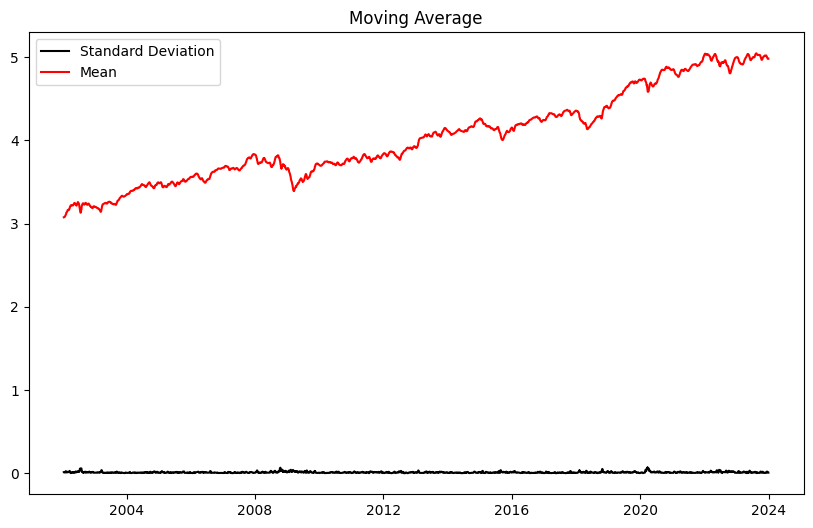

In [55]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(pg["PG"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Date
2020-09-11    4.848298
2020-09-14    4.851839
2020-09-15    4.851839
2020-09-16    4.845107
2020-09-17    4.843800
                ...   
2023-12-22    4.978663
2023-12-26    4.983196
2023-12-27    4.984017
2023-12-28    4.981756
2023-12-29    4.987298
Name: PG, Length: 831, dtype: float64


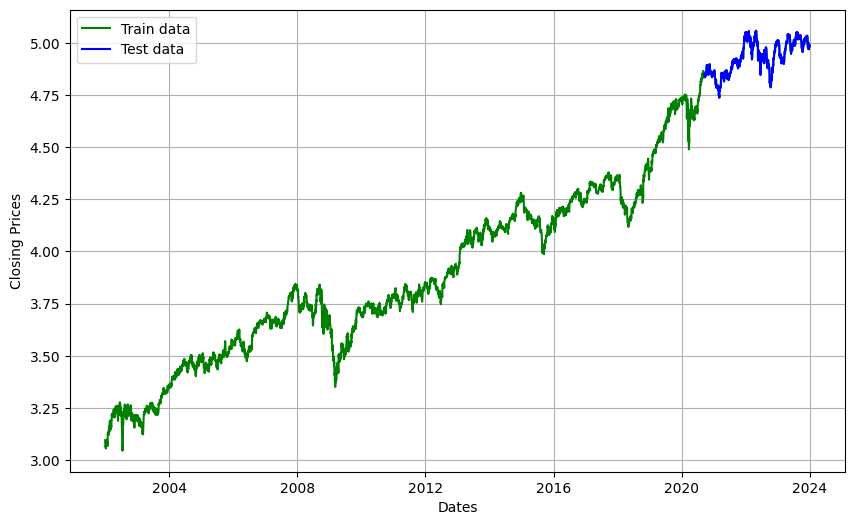

In [56]:
train_data, test_data = df_log[3:int(len(df_log)*0.85)], df_log[int(len(df_log)*0.85):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
print(test_data)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-28618.041, Time=1.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-28666.670, Time=2.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-28671.006, Time=1.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-28615.012, Time=0.49 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28676.773, Time=5.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28672.412, Time=3.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28673.845, Time=1.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-28675.844, Time=2.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-28674.405, Time=1.47 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-28677.195, Time=7.94 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-28681.255, Time=9.48 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-28670.383, Time=8.11 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-28689.267, Time=6.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-28692.046, Time=6.53 sec
 ARIM

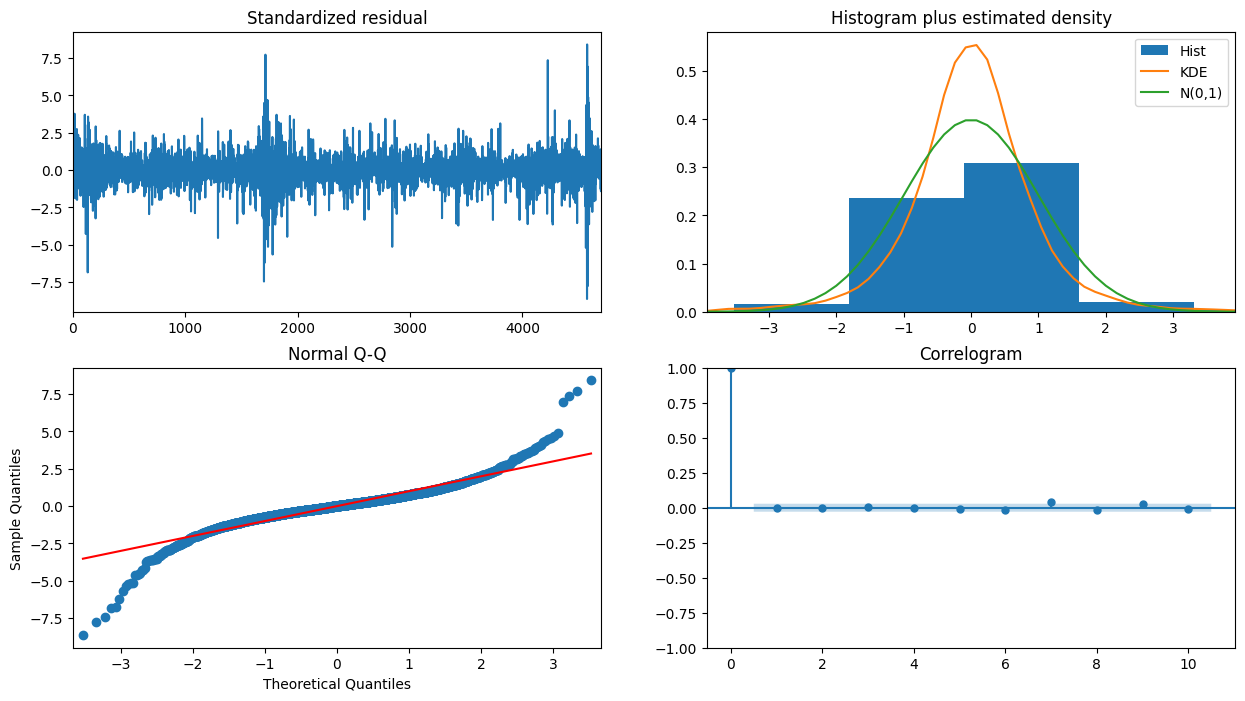

In [57]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [58]:
model = sm.tsa.arima.ARIMA(train_data, order=(4,1,0), trend="t")
result = model.fit()
  
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                     PG   No. Observations:                 4703
Model:                 ARIMA(4, 1, 0)   Log Likelihood               14352.842
Date:                Tue, 09 Jan 2024   AIC                         -28693.685
Time:                        13:49:11   BIC                         -28654.950
Sample:                             0   HQIC                        -28680.067
                               - 4703                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0004      0.000      2.655      0.008    9.84e-05       0.001
ar.L1         -0.1081      0.007    -15.585      0.000      -0.122      -0.095
ar.L2         -0.0486      0.007     -7.096      0.0

In [59]:
predicted = result.predict()
predicted = pd.DataFrame(predicted)

fc = result.forecast(831)
fc = pd.DataFrame(fc)
indeks = test_data.index
fc = fc.set_index(indeks)
predicted = predicted.iloc[1: , :]
predicted

predicted_mean
Date                      
2002-01-08        3.064135
2002-01-09        3.066598
2002-01-10        3.060329
2002-01-11        3.056874
2002-01-14        3.059466
...                    ...
2020-09-03        4.863755
2020-09-04        4.850794
2020-09-08        4.848437
2020-09-09        4.833344
2020-09-10        4.848957

[4702 rows x 1 columns]

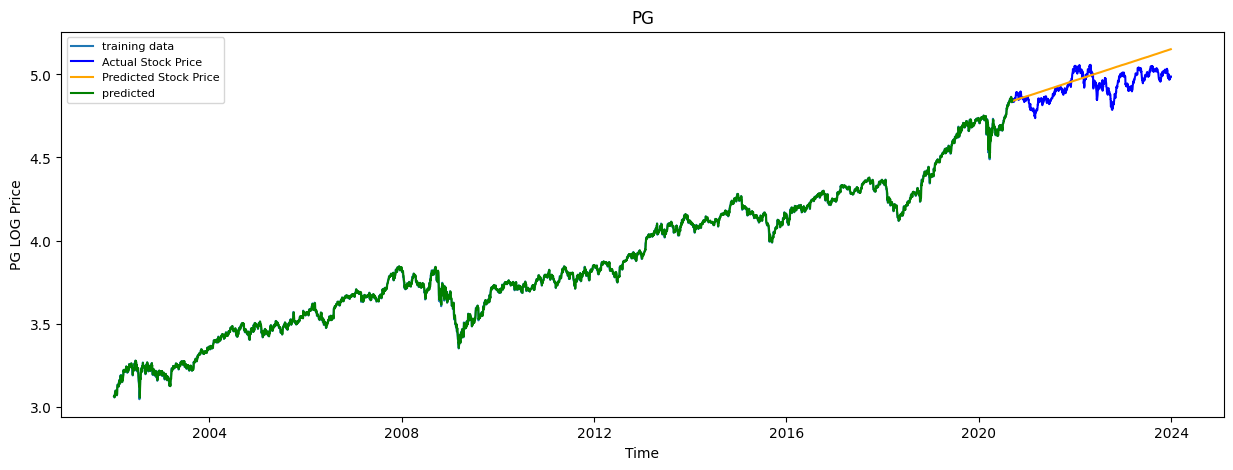

In [60]:
plt.figure(figsize=(15,5))
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc, color = 'orange',label='Predicted Stock Price')
plt.plot(predicted, color ="green", label = "predicted")
plt.title('PG')
plt.xlabel('Time')
plt.ylabel('PG LOG Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [61]:
mse_pg_arima = mean_squared_error(test_data, fc)
print('MSE: '+str(mse_pg_arima))
rmse_pg_arima = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse_pg_arima))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.008508648880224713
RMSE: 0.09224233778599018
MAPE: nan


In [62]:
pg_forecast = pd.concat([predicted, fc], axis=0)
pg_forecast

predicted_mean
Date                      
2002-01-08        3.064135
2002-01-09        3.066598
2002-01-10        3.060329
2002-01-11        3.056874
2002-01-14        3.059466
...                    ...
2023-12-22        5.150087
2023-12-26        5.150463
2023-12-27        5.150839
2023-12-28        5.151214
2023-12-29        5.151590

[5533 rows x 1 columns]

In [63]:
arıma_fc = pd.concat([pg_forecast, msft_forecast, ko_forecast, jpm_forecast], axis=1)
arıma_fc.columns = ["PG", "MSFT", "KO", "JPM"]
arıma_fc

PG      MSFT        KO       JPM
Date                                              
2002-01-08  3.064135  3.056941  2.485231  3.019325
2002-01-09  3.066598  3.067387  2.473230  3.012441
2002-01-10  3.060329  3.060249  2.470650  3.014220
2002-01-11  3.056874  3.066531  2.475208  3.024476
2002-01-14  3.059466  3.058871  2.486404  3.007295
...              ...       ...       ...       ...
2023-12-22  5.150087  5.690284  4.037252  4.764365
2023-12-26  5.150463  5.690758  4.037533  4.764677
2023-12-27  5.150839  5.691231  4.037814  4.764989
2023-12-28  5.151214  5.691704  4.038094  4.765302
2023-12-29  5.151590  5.692178  4.038375  4.765614

[5533 rows x 4 columns]

In [64]:
np.random.seed(100)
# Weight each security
weights = np.random.random((4,1))
# normalize it, so that some is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
arıma_fc = np.exp(arıma_fc)
log_ret_arıma = np.log(arıma_fc / arıma_fc.shift(1))
log_ret_arıma

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret_arıma = log_ret_arıma.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret_arıma[0]}')

# Exp Volatility (Risk)
exp_vol_arıma = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol_arıma[0][0]}')

# Sharpe ratio
sr = exp_ret_arıma / exp_vol_arıma
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [0.25986956 0.13312306 0.20301472 0.40399265]

Expected return of the portfolio is : 0.08719217608101724

Volatility of the portfolio: 0.19456488328457888

Sharpe ratio of the portfolio: 0.4481393281720127


In [65]:
# number of simulation
n = 10000


port_weights = np.zeros(shape=(n,len(arıma_fc.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(arıma_fc.columns)
# num_securities
for i in range(n):
    # Weight each security
    weights = np.random.random(4)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret_arıma = log_ret_arıma.mean().dot(weights)*252 
    port_return[i] = exp_ret_arıma
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol_arıma = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol_arıma
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret_arıma / exp_vol_arıma
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [66]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]
max_sr
arima_portfolio_stat = np.array([max_sr_ret, max_sr_vol, max_sr])

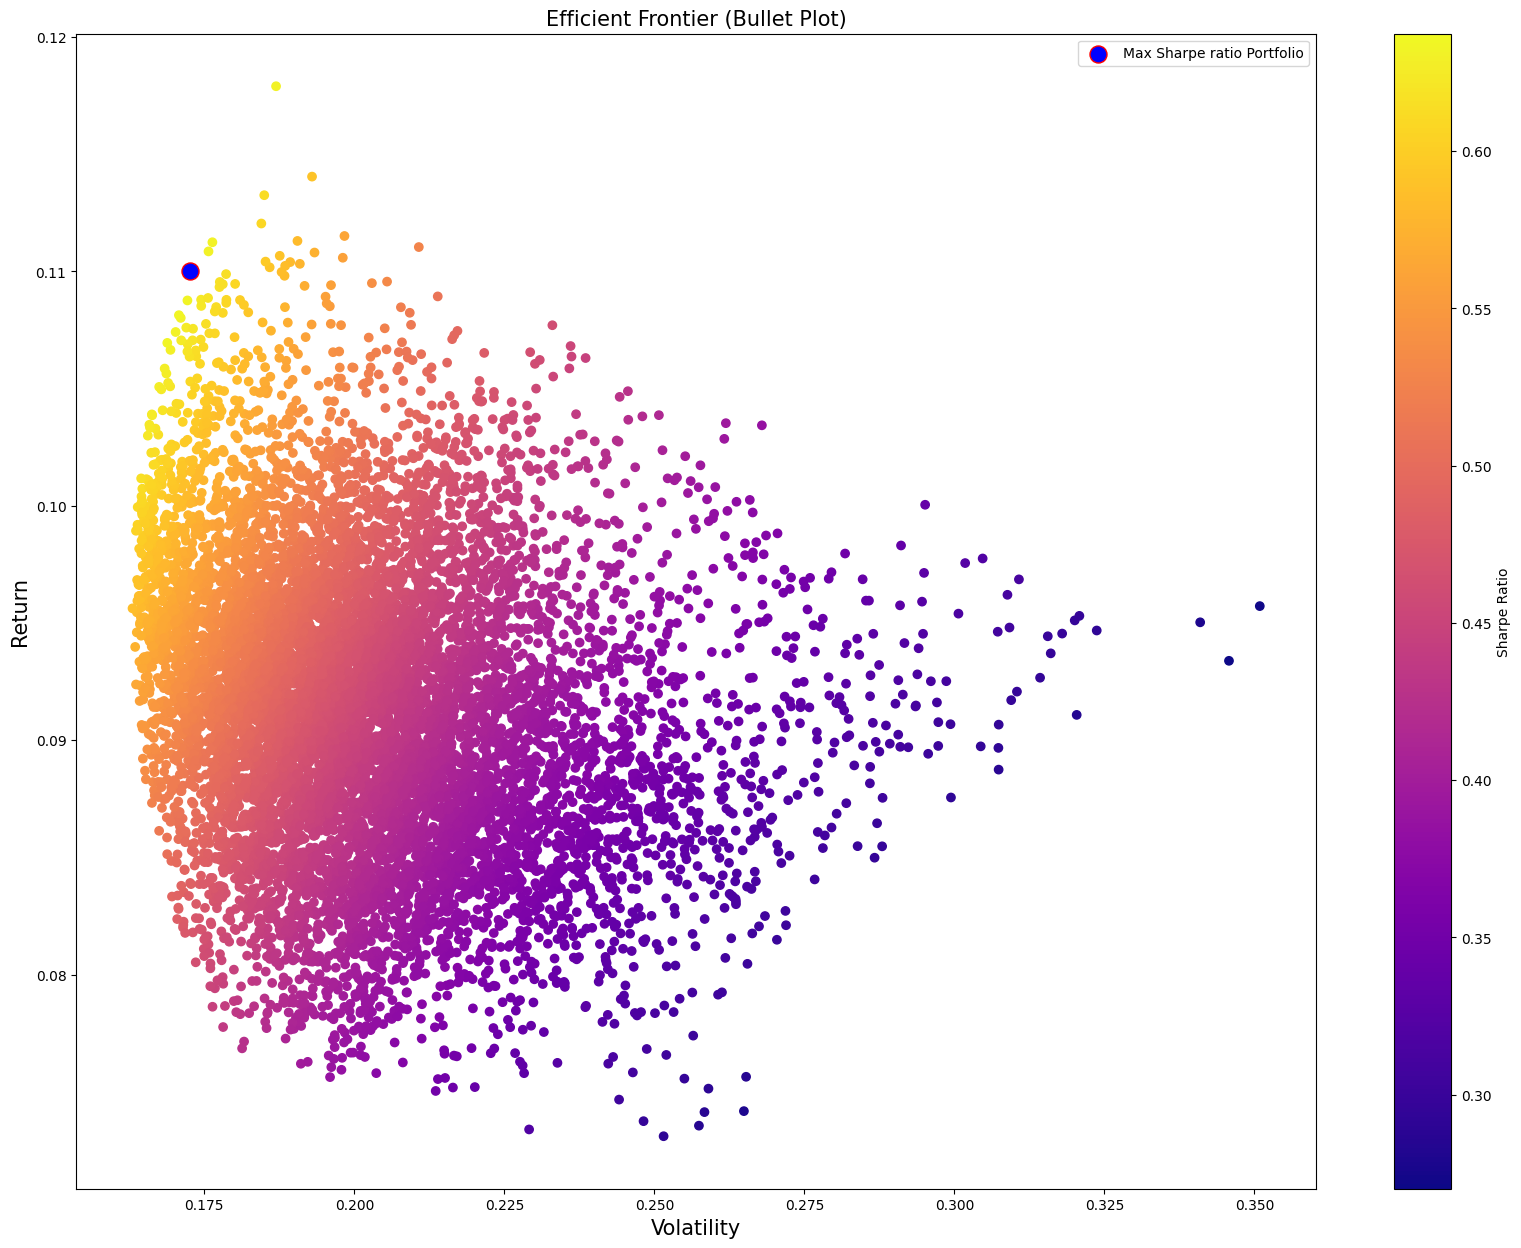

In [67]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier (Bullet Plot)', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();
plt.savefig('arima_dist.png')

1.33 % of PG should be bought.
75.11 % of KO should be bought.
1.52 % of MSFT should be bought.
22.04 % of JPM should be bought.

Markowitz optimal portfolio based on Arıma forecast return is : 11.0% with volatility 0.1726454064995509


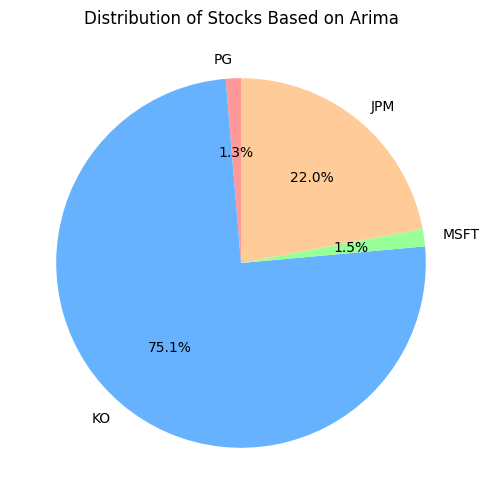

In [68]:
ticker_list = ['PG','KO','MSFT','JPM']
for weight, stocks in zip(port_weights[ind], ticker_list):
    print(f'{round(weight * 100, 2)} % of {stocks} should be bought.')
    
# best portfolio return
print(f'\nMarkowitz optimal portfolio based on Arıma forecast return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')

plt.pie(port_weights[ind], labels=ticker_list, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.title('Distribution of Stocks Based on Arima')
plt.savefig('arima_opt_dist.png')

In [69]:
arıma_fc = pd.concat([pg_forecast, msft_forecast, ko_forecast, jpm_forecast], axis=1)
arıma_fc.columns = ["PG", "MSFT", "KO", "JPM"]
arıma_fc
daily_portfolio_value = arıma_fc.dot(port_weights[ind])
daily_portfolio_value

Date
2002-01-08    3.040033
2002-01-09    3.046211
2002-01-10    3.041120
2002-01-11    3.048122
2002-01-14    3.038787
                ...   
2023-12-22    5.453843
2023-12-26    5.454277
2023-12-27    5.454710
2023-12-28    5.455144
2023-12-29    5.455577
Length: 5533, dtype: float64

In [70]:
daily_returns = daily_portfolio_value.pct_change()
daily_returns

Date
2002-01-08         NaN
2002-01-09    0.002032
2002-01-10   -0.001671
2002-01-11    0.002302
2002-01-14   -0.003063
                ...   
2023-12-22    0.000080
2023-12-26    0.000080
2023-12-27    0.000080
2023-12-28    0.000079
2023-12-29    0.000079
Length: 5533, dtype: float64

In [71]:
# Calculate cumulative returns
cumulative_returns_arima = (1 + daily_returns).cumprod()
cumulative_returns_arima

Date
2002-01-08         NaN
2002-01-09    1.002032
2002-01-10    1.000357
2002-01-11    1.002661
2002-01-14    0.999590
                ...   
2023-12-22    1.794008
2023-12-26    1.794150
2023-12-27    1.794293
2023-12-28    1.794436
2023-12-29    1.794578
Length: 5533, dtype: float64

In [72]:
total_return = cumulative_returns_arima.iloc[-1] - 1
total_return

0.7945784074036626

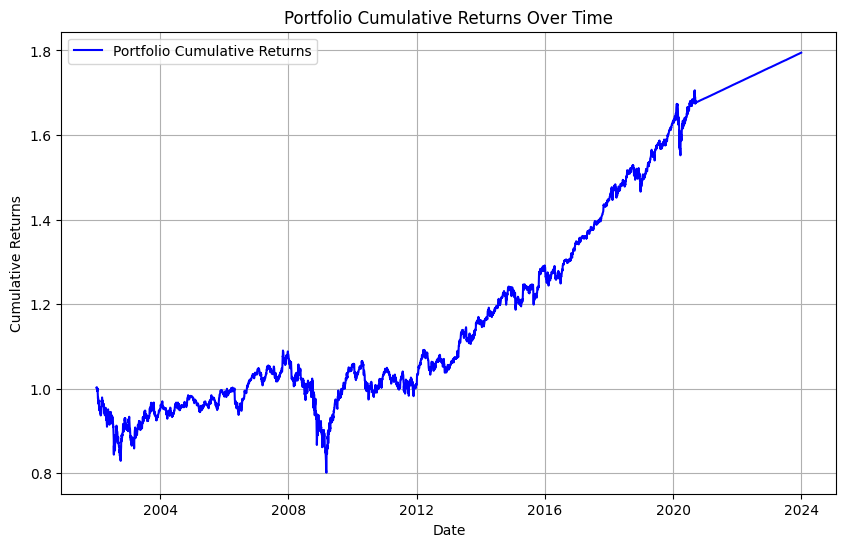

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_arima.index, cumulative_returns_arima, label='Portfolio Cumulative Returns', color='blue')
plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
#Random Forest Forecasting

from sklearn.ensemble import RandomForestRegressor 


start_date =datetime.datetime(2002,1,1)
end_date = datetime.datetime(2023,12,30)
def get_stock_price(ticker):
    prices = yf.download(ticker,start_date,end_date)
    #prices = prices["Adj Close", "Open", "High", "Low"].dropna(how="all") 
    return prices


ticker_list = ['PG','KO','MSFT','JPM']
portfoli = get_stock_price(ticker_list)

portfoli

[*********************100%%**********************]  4 of 4 completed


Adj Close                                          Close  \
                   JPM         KO        MSFT          PG         JPM   
Date                                                                    
2002-01-02   19.129133  12.597630   20.781187   22.084211   36.349998   
2002-01-03   19.639597  12.433097   21.460045   21.871655   37.320000   
2002-01-04   20.523693  12.321631   21.357754   21.656321   39.000000   
2002-01-07   20.471075  12.000525   21.252354   21.407881   38.900002   
2002-01-08   20.313196  11.849257   21.506548   21.465851   38.599998   
...                ...        ...         ...         ...         ...   
2023-12-22  166.374069  58.320000  374.579987  145.279999  167.399994   
2023-12-26  167.358017  58.560001  374.660004  145.940002  168.389999   
2023-12-27  168.361816  58.709999  374.070007  146.059998  169.399994   
2023-12-28  169.256317  58.750000  375.279999  145.729996  170.300003   
2023-12-29  169.057541  58.930000  376.040009  146.539993  170.100006   

                                                     High             ...  \
                   KO        MSFT          PG         JPM         KO  ...   
Date                                                                  ...   
2002-01-02  23.735001   33.520000   40.000000   36.490002  23.820000  ...   
2002-01-03  23.424999   34.615002   39.615002   37.500000  23.825001  ...   
2002-01-04  23.215000   34.450001   39.224998   39.099998  23.320000  ...   
2002-01-07  22.610001   34.279999   38.775002   39.680000  23.500000  ...   
2002-01-08  22.325001   34.689999   38.880001   39.049999  22.735001  ...   
...               ...         ...         ...         ...        ...  ...   
2023-12-22  58.320000  374.579987  145.279999  168.229996  58.459999  ...   
2023-12-26  58.560001  374.660004  145.940002  168.770004  58.709999  ...   
2023-12-27  58.709999  374.070007  146.059998  169.470001  58.770000  ...   
2023-12-28  58.750000  375.279999  145.729996  170.660004  58.869999  ...   
2023-12-29  58.930000  376.040009  146.539993  170.690002  58.980000  ...   

                   Low                    Open                         \
                  MSFT          PG         JPM         KO        MSFT   
Date                                                                    
2002-01-02   32.755001   39.009998   36.490002  23.400000   33.325001   
2002-01-03   33.544998   39.305000   36.500000  23.825001   33.555000   
2002-01-04   34.334999   39.099998   38.020000  23.299999   34.625000   
2002-01-07   34.174999   38.549999   39.049999  22.950001   34.875000   
2002-01-08   34.000000   38.639999   39.000000  22.735001   34.345001   
...                ...         ...         ...        ...         ...   
2023-12-22  372.709991  144.289993  167.500000  58.119999  373.679993   
2023-12-26  373.500000  144.970001  167.460007  58.060001  375.000000   
2023-12-27  372.809998  145.360001  167.839996  58.639999  373.690002   
2023-12-28  374.160004  145.039993  169.350006  58.650002  375.369995   
2023-12-29  373.480011  145.729996  170.000000  58.740002  376.000000   

                          Volume                               
                    PG       JPM        KO      MSFT       PG  
Date                                                           
2002-01-02   39.450001   7929300   8848000  48124000  6261600  
2002-01-03   39.654999  10348200  10789800  67590800  5216800  
2002-01-04   39.619999  10432900  10145600  52731400  6181400  
2002-01-07   39.115002   9453000  17142800  58508800  6412200  
2002-01-08   38.775002   7604000  12292800  47736400  4009800  
...                ...       ...       ...       ...      ...  
2023-12-22  144.500000   6574900   9028500  17091100  4412800  
2023-12-26  145.089996   4683600   6422500  12673100  3634900  
2023-12-27  145.649994   6428600   8560100  14905400  4569400  
2023-12-28  146.000000   6320100   8400100  14327000  5023000  
2023-12-29  146.000000   6431800   9241600  18723000  53

In [75]:
y= np.log(portfoli["Adj Close"]["KO"])
y

Date
2002-01-02    2.533509
2002-01-03    2.520362
2002-01-04    2.511356
2002-01-07    2.484950
2002-01-08    2.472265
                ...   
2023-12-22    4.065945
2023-12-26    4.070052
2023-12-27    4.072610
2023-12-28    4.073291
2023-12-29    4.076350
Name: KO, Length: 5537, dtype: float64

In [76]:
ko_low = np.log(portfoli["Low"]["KO"])
ko_high = np.log(portfoli["High"]["KO"])
ko_close = np.log(portfoli["Close"]["KO"])

x= pd.concat([ko_low, ko_high,ko_close], axis=1)
x.columns = ["low","high","close"]
x


low      high     close
Date                                    
2002-01-02  3.141130  3.170526  3.166951
2002-01-03  3.146305  3.170735  3.153804
2002-01-04  3.135929  3.149311  3.144799
2002-01-07  3.109061  3.157000  3.118392
2002-01-08  3.105259  3.123906  3.105707
...              ...       ...       ...
2023-12-22  4.060788  4.068343  4.065945
2023-12-26  4.061477  4.072610  4.070052
2023-12-27  4.067316  4.073632  4.072610
2023-12-28  4.069539  4.075332  4.073291
2023-12-29  4.071247  4.077198  4.076350

[5537 rows x 3 columns]

In [77]:
X_train, X_test = x[3:int(len(x)*0.85)], x[int(len(x)*0.85):]
y_train, y_test = y[3:int(len(y)*0.85)], y[int(len(y)*0.85):]

In [78]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler(feature_range=(0,1))
 
## Transform the data into
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [79]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [80]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}  



In [81]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt", max_depth = 120, bootstrap = True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred

array([3.79587023, 3.78679662, 3.79917527, 3.79503495, 3.77918379,
       3.78583269, 3.7539714 , 3.75004332, 3.76085586, 3.72791651,
       3.74010196, 3.74360938, 3.7443901 , 3.74522212, 3.74853178,
       3.74821364, 3.74270287, 3.75499454, 3.74768637, 3.77136418,
       3.78756439, 3.79614588, 3.7923416 , 3.76627034, 3.76383412,
       3.77408765, 3.75891345, 3.78483307, 3.76587889, 3.78492317,
       3.78609312, 3.76297716, 3.75288239, 3.73141698, 3.74805395,
       3.74227623, 3.74149641, 3.74486793, 3.74921012, 3.76202025,
       3.74722315, 3.82610851, 3.85054325, 3.84752203, 3.83664117,
       3.84115436, 3.85030553, 3.8479472 , 3.83403014, 3.83131995,
       3.83392679, 3.82935418, 3.84044851, 3.83743252, 3.83454096,
       3.80122713, 3.81306519, 3.81241294, 3.82745234, 3.85342304,
       3.83463673, 3.83744963, 3.84200377, 3.83647243, 3.84339598,
       3.84617759, 3.85292584, 3.83649601, 3.84594223, 3.84859412,
       3.82907548, 3.83368542, 3.83736856, 3.84246641, 3.86019

In [82]:
y_train_pred = regressor.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred

0
0     2.523740
1     2.503407
2     2.487557
3     2.509836
4     2.519185
...        ...
4698  3.806109
4699  3.813260
4700  3.788974
4701  3.786911
4702  3.787101

[4703 rows x 1 columns]

In [83]:
y_pred = pd.DataFrame(y_pred)
indekss = y_test.index
y_pred = y_pred.set_index(indekss)
indeks1 = y_train.index
y_train_pred = y_train_pred.set_index(indeks1)
y_pred
y_train_pred

0
Date                
2002-01-07  2.523740
2002-01-08  2.503407
2002-01-09  2.487557
2002-01-10  2.509836
2002-01-11  2.519185
...              ...
2020-09-03  3.806109
2020-09-04  3.813260
2020-09-08  3.788974
2020-09-09  3.786911
2020-09-10  3.787101

[4703 rows x 1 columns]

In [84]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
RSME = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
ko_forest_mse = metrics.mean_absolute_error(y_test, y_pred)
ko_forest_rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.09121286455046976
Mean Squared Error: 0.009795767375481594
Root Mean Squared Error: 0.09897356907519095


In [85]:
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
accuracy = r2_score(y_test, y_pred)
print("Train r2_score:",r2_score(y_test, y_pred))

Train r2_score: 0.021458923733951196


In [86]:
from sklearn.metrics import r2_score   
r2_score(y_test, y_pred)   
adjustedaccuracy = 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1))
print(1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

0.01790919794338508


In [87]:
ko_forest_fc = pd.concat([y_train_pred,y_pred], axis=0)
ko_forest_fc


0
Date                
2002-01-07  2.523740
2002-01-08  2.503407
2002-01-09  2.487557
2002-01-10  2.509836
2002-01-11  2.519185
...              ...
2023-12-22  3.939739
2023-12-26  3.941657
2023-12-27  3.947146
2023-12-28  3.948687
2023-12-29  3.950258

[5534 rows x 1 columns]

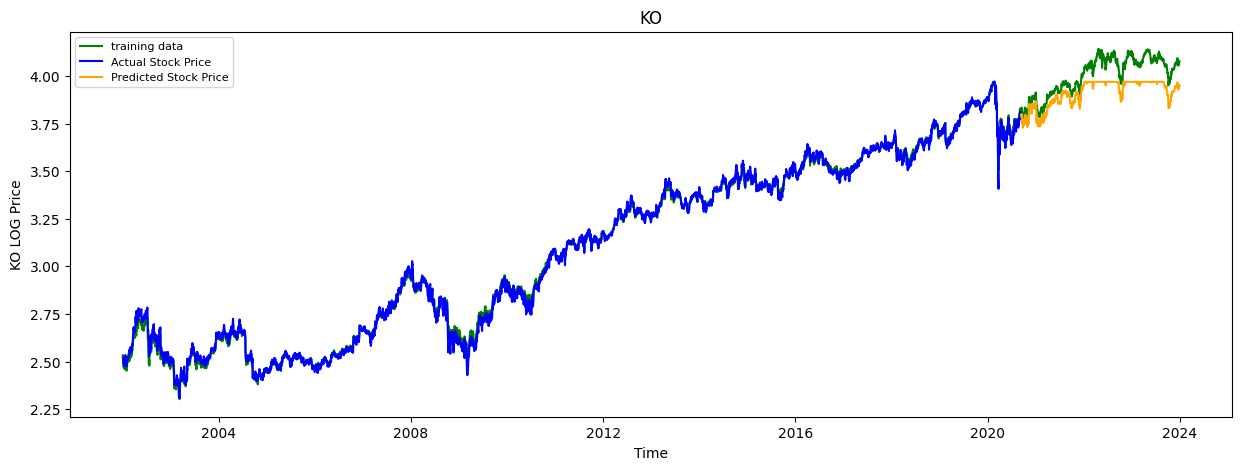

In [88]:
plt.figure(figsize=(15,5))
plt.plot(y, color = "green",label='training data')
plt.plot(y_train_pred, color = 'blue', label='Actual Stock Price')
plt.plot(y_pred, color = 'orange',label='Predicted Stock Price')
plt.title('KO')
plt.xlabel('Time')
plt.ylabel('KO LOG Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [89]:
y= np.log(portfoli["Adj Close"]["JPM"])
y
jpm_low = np.log(portfoli["Low"]["JPM"])
jpm_high = np.log(portfoli["High"]["JPM"])
jpm_close = np.log(portfoli["Close"]["JPM"])

x= pd.concat([jpm_low, jpm_high,jpm_close], axis=1)
x.columns = ["low","high","close"]
x
X_train, X_test = x[3:int(len(x)*0.85)], x[int(len(x)*0.85):]
y_train, y_test = y[3:int(len(y)*0.85)], y[int(len(y)*0.85):]
scaler = MinMaxScaler(feature_range=(0,1))
 
## Transform the data into
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [90]:
n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [91]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}  



In [92]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt", max_depth = 120, bootstrap = True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred


array([4.47337279, 4.49792896, 4.478336  , 4.47974666, 4.47312938,
       4.47362037, 4.40819864, 4.39017623, 4.40158619, 4.40203782,
       4.38697727, 4.43591211, 4.40709176, 4.4175583 , 4.45537718,
       4.45079625, 4.4669047 , 4.45793492, 4.46891551, 4.46506301,
       4.46902344, 4.48693645, 4.46881883, 4.46992091, 4.46825443,
       4.45530121, 4.48163859, 4.45230493, 4.46208713, 4.50565396,
       4.48950018, 4.47645805, 4.45823018, 4.43005972, 4.45037971,
       4.43081053, 4.48069053, 4.48775074, 4.48761798, 4.51783645,
       4.48471649, 4.60039476, 4.6015918 , 4.57920255, 4.5834642 ,
       4.57877963, 4.6120779 , 4.60361423, 4.59002002, 4.59661721,
       4.58081432, 4.60805634, 4.68447453, 4.66996061, 4.67225966,
       4.63332352, 4.66147591, 4.66711806, 4.66925457, 4.67851986,
       4.66935835, 4.6719509 , 4.67219272, 4.65902495, 4.6496804 ,
       4.64206951, 4.65823052, 4.66374719, 4.65965537, 4.64530048,
       4.68866671, 4.67942549, 4.70005351, 4.69982733, 4.70661

In [93]:
y_train_pred = regressor.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred

0
0     3.112767
1     3.067276
2     3.070376
3     3.118378
4     3.081738
...        ...
4698  4.498897
4699  4.528846
4700  4.497381
4701  4.493767
4702  4.496666

[4703 rows x 1 columns]

In [94]:
y_pred = pd.DataFrame(y_pred)
indekss = y_test.index
y_pred = y_pred.set_index(indekss)
indeks1 = y_train.index
y_train_pred = y_train_pred.set_index(indeks1)
y_pred
y_train_pred
jpm_forest_fc = pd.concat([y_train_pred,y_pred], axis=0)
jpm_forest_fc

0
Date                
2002-01-07  3.112767
2002-01-08  3.067276
2002-01-09  3.070376
2002-01-10  3.118378
2002-01-11  3.081738
...              ...
2023-12-22  4.817795
2023-12-26  4.817795
2023-12-27  4.817795
2023-12-28  4.817795
2023-12-29  4.817795

[5534 rows x 1 columns]

In [95]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
RSME = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
jpm_forest_mse = metrics.mean_absolute_error(y_test, y_pred)
jpm_forest_rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.12616676451486195
Mean Squared Error: 0.019424428127467298
Root Mean Squared Error: 0.13937154705128052


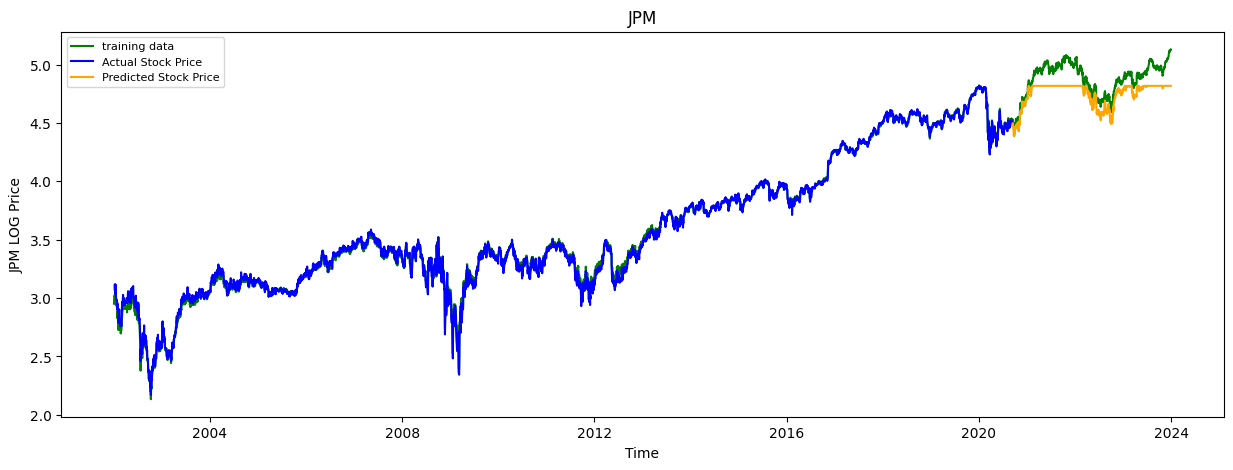

In [96]:
plt.figure(figsize=(15,5))
plt.plot(y, color = "green",label='training data')
plt.plot(y_train_pred, color = 'blue', label='Actual Stock Price')
plt.plot(y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('JPM')
plt.xlabel('Time')
plt.ylabel('JPM LOG Price')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('forest_jpm_forecast.png')
plt.show()


In [97]:
y= np.log(portfoli["Adj Close"]["MSFT"])
y
msft_low = np.log(portfoli["Low"]["MSFT"])
msft_high = np.log(portfoli["High"]["MSFT"])
msft_close = np.log(portfoli["Close"]["MSFT"])

x= pd.concat([msft_low, msft_high,msft_close], axis=1)
x.columns = ["low","high","close"]
x
X_train, X_test = x[3:int(len(x)*0.85)], x[int(len(x)*0.85):]
y_train, y_test = y[3:int(len(y)*0.85)], y[int(len(y)*0.85):]
scaler = MinMaxScaler(feature_range=(0,1))
 
## Transform the data into
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}  



In [99]:
regressor = RandomForestRegressor(n_estimators=100, min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt", max_depth = 10, bootstrap = False)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred


array([5.28864319, 5.30093517, 5.30908786, 5.29767502, 5.28220676,
       5.26755663, 5.26859064, 5.30422925, 5.27912756, 5.28638315,
       5.30455097, 5.31225304, 5.30671389, 5.3150561 , 5.32998571,
       5.30391722, 5.31426666, 5.30572706, 5.31414462, 5.31969391,
       5.33491259, 5.36972485, 5.38124429, 5.37620182, 5.36160783,
       5.37620182, 5.34841783, 5.34260237, 5.34260237, 5.33448558,
       5.34158806, 5.32579346, 5.32979905, 5.286115  , 5.28520741,
       5.28212033, 5.28345574, 5.29833929, 5.34444769, 5.37745539,
       5.38029991, 5.36230942, 5.33024201, 5.34437746, 5.34588215,
       5.34766033, 5.34844381, 5.34286167, 5.32837629, 5.32942634,
       5.32316498, 5.31780975, 5.3304489 , 5.33303727, 5.33871807,
       5.3331505 , 5.34701252, 5.33534706, 5.3422049 , 5.33626885,
       5.33626885, 5.34497964, 5.32856756, 5.32400375, 5.32837683,
       5.33459077, 5.33356392, 5.35499209, 5.36972485, 5.34832493,
       5.36972485, 5.39307292, 5.37620182, 5.37745539, 5.39307

In [100]:
y_train_pred = regressor.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred

0
0     3.094661
1     3.121619
2     3.088475
3     3.118640
4     3.094636
...        ...
4698  5.351633
4699  5.338386
4700  5.284204
4701  5.323396
4702  5.299541

[4703 rows x 1 columns]

In [101]:
y_pred = pd.DataFrame(y_pred)
indekss = y_test.index
y_pred = y_pred.set_index(indekss)
indeks1 = y_train.index
y_train_pred = y_train_pred.set_index(indeks1)
y_pred
y_train_pred
msft_forest_fc = pd.concat([y_train_pred,y_pred], axis=0)
msft_forest_fc

0
Date                
2002-01-07  3.094661
2002-01-08  3.121619
2002-01-09  3.088475
2002-01-10  3.118640
2002-01-11  3.094636
...              ...
2023-12-22  5.416111
2023-12-26  5.416111
2023-12-27  5.416111
2023-12-28  5.416111
2023-12-29  5.416111

[5534 rows x 1 columns]

In [102]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
RSME = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
msft_forest_mse = metrics.mean_absolute_error(y_test, y_pred)
msft_forest_rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.19915005103185726
Mean Squared Error: 0.0614870649439802
Root Mean Squared Error: 0.24796585439124516


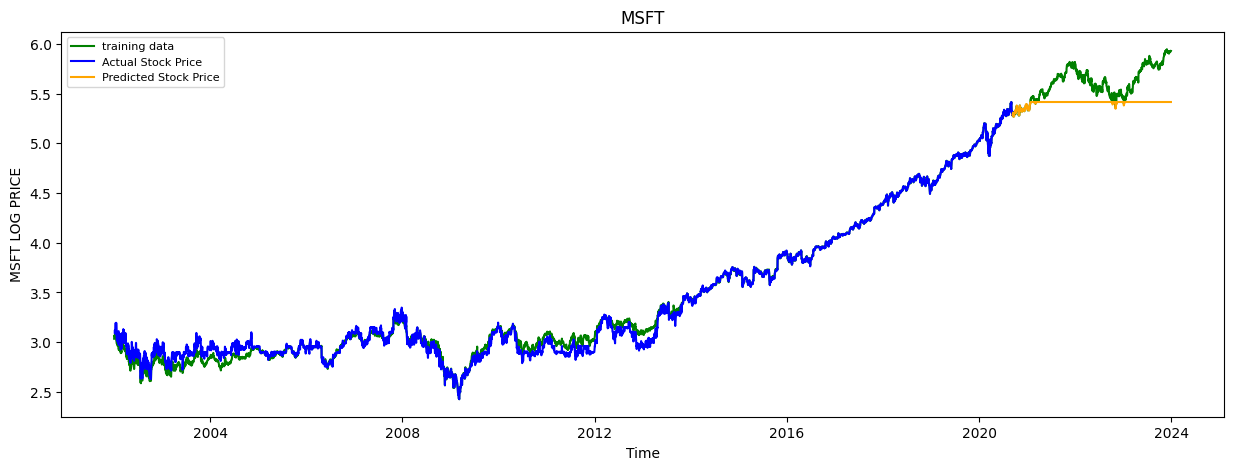

In [103]:
plt.figure(figsize=(15,5))
plt.plot(y, color = "green",label='training data')
plt.plot(y_train_pred, color = 'blue', label='Actual Stock Price')
plt.plot(y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('MSFT')
plt.xlabel('Time')
plt.ylabel('MSFT LOG PRICE')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [104]:
y= np.log(portfoli["Adj Close"]["PG"])
y
pg_low = np.log(portfoli["Low"]["PG"])
pg_high = np.log(portfoli["High"]["PG"])
pg_close = np.log(portfoli["Close"]["PG"])

x= pd.concat([pg_low, pg_high,pg_close], axis=1)
x.columns = ["low","high","close"]
x
X_train, X_test = x[3:int(len(x)*0.85)], x[int(len(x)*0.85):]
y_train, y_test = y[3:int(len(y)*0.85)], y[int(len(y)*0.85):]
scaler = MinMaxScaler(feature_range=(0,1))
 
## Transform the data into
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [105]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)
rf_random.fit(X_train, y_train)

print ('Best Parameters: ', rf_random.best_params_, ' \n')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}  



In [106]:
regressor = RandomForestRegressor(n_estimators=20, min_samples_split = 2, min_samples_leaf = 1, max_features = "sqrt", max_depth = 80, bootstrap = True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred


array([4.84818427, 4.8502995 , 4.85032122, 4.8487654 , 4.84493243,
       4.8431531 , 4.83527949, 4.84881668, 4.84047499, 4.83904261,
       4.8444056 , 4.84904473, 4.84294456, 4.85191137, 4.85164819,
       4.84957219, 4.85164819, 4.85793459, 4.85865141, 4.85703713,
       4.85703713, 4.85703713, 4.85703713, 4.85703713, 4.85703713,
       4.85703713, 4.85703713, 4.85703713, 4.85703713, 4.85703713,
       4.85703713, 4.85703713, 4.85703713, 4.85192809, 4.84541135,
       4.83606575, 4.85018745, 4.85703713, 4.85703713, 4.85703713,
       4.85703713, 4.85347332, 4.8561432 , 4.85703713, 4.85703713,
       4.85703713, 4.85703713, 4.85703713, 4.85703713, 4.85164819,
       4.85305307, 4.85164819, 4.84945815, 4.85162711, 4.85203499,
       4.85192205, 4.85162648, 4.84976471, 4.84051086, 4.84358458,
       4.84410491, 4.84773639, 4.84047647, 4.83114829, 4.83412501,
       4.8365385 , 4.83999141, 4.84290265, 4.85017148, 4.85186437,
       4.8451654 , 4.84001771, 4.83947029, 4.84552733, 4.85162

In [107]:
y_train_pred = regressor.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred)
y_train_pred

0
0     3.064658
1     3.067646
2     3.060587
3     3.057016
4     3.060632
...        ...
4698  4.851512
4699  4.847876
4700  4.833142
4701  4.848265
4702  4.841031

[4703 rows x 1 columns]

In [108]:
y_pred = pd.DataFrame(y_pred)
indekss = y_test.index
y_pred = y_pred.set_index(indekss)
indeks1 = y_train.index
y_train_pred = y_train_pred.set_index(indeks1)
y_pred
y_train_pred
pg_forest_fc = pd.concat([y_train_pred,y_pred], axis=0)
pg_forest_fc

0
Date                
2002-01-07  3.064658
2002-01-08  3.067646
2002-01-09  3.060587
2002-01-10  3.057016
2002-01-11  3.060632
...              ...
2023-12-22  4.857037
2023-12-26  4.857037
2023-12-27  4.857037
2023-12-28  4.857037
2023-12-29  4.857037

[5534 rows x 1 columns]

In [109]:

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
RSME = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
pg_forest_mse = metrics.mean_absolute_error(y_test, y_pred)
pg_forest_rsme = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

Mean Absolute Error: 0.08618299675788202
Mean Squared Error: 0.011000538888358228
Root Mean Squared Error: 0.10488345383499834


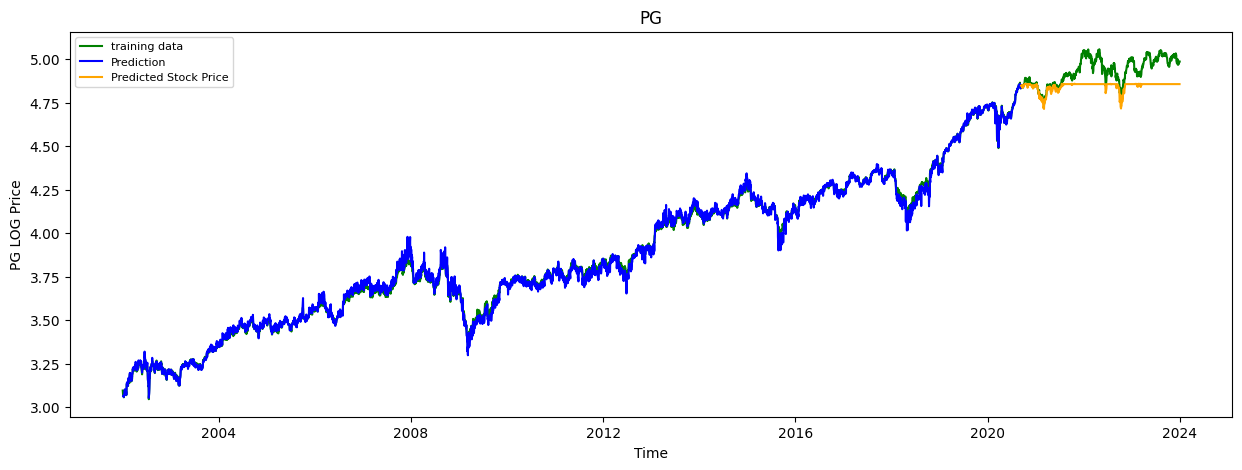

In [110]:
plt.figure(figsize=(15,5))
plt.plot(y, color = "green",label='training data')
plt.plot(y_train_pred, color = 'blue', label='Prediction')
plt.plot(y_pred, color = 'orange',label='Predicted Stock Price')

plt.title('PG')
plt.xlabel('Time')
plt.ylabel('PG LOG Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [111]:
forest_fc = pd.concat([pg_forest_fc, msft_forest_fc, ko_forest_fc, jpm_forest_fc], axis=1)
forest_fc.columns = ["PG", "MSFT", "KO", "JPM"]
forest_fc


PG      MSFT        KO       JPM
Date                                              
2002-01-07  3.064658  3.094661  2.523740  3.112767
2002-01-08  3.067646  3.121619  2.503407  3.067276
2002-01-09  3.060587  3.088475  2.487557  3.070376
2002-01-10  3.057016  3.118640  2.509836  3.118378
2002-01-11  3.060632  3.094636  2.519185  3.081738
...              ...       ...       ...       ...
2023-12-22  4.857037  5.416111  3.939739  4.817795
2023-12-26  4.857037  5.416111  3.941657  4.817795
2023-12-27  4.857037  5.416111  3.947146  4.817795
2023-12-28  4.857037  5.416111  3.948687  4.817795
2023-12-29  4.857037  5.416111  3.950258  4.817795

[5534 rows x 4 columns]

In [112]:
np.random.seed(100)
# Weight each security
weights = np.random.random((4,1))
# normalize it, so that some is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
forest_fc = np.exp(forest_fc)
log_ret = np.log(forest_fc / forest_fc.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return of the portfolio is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility of the portfolio: {exp_vol[0][0]}')

# Sharpe ratio
sr = exp_ret / exp_vol
print(f'\nSharpe ratio of the portfolio: {sr[0][0]}')

Normalized Weights : [0.25986956 0.13312306 0.20301472 0.40399265]

Expected return of the portfolio is : 0.07985145754888628

Volatility of the portfolio: 0.24077662232623112

Sharpe ratio of the portfolio: 0.3316412398239169


In [113]:
# number of simulation
n = 10000


port_weights = np.zeros(shape=(n,len(forest_fc.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(forest_fc.columns)
# num_securities
for i in range(n):
    # Weight each security
    weights = np.random.random(4)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret / exp_vol
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [114]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]
max_sr
forest_portfolio_stat = np.array([max_sr_ret, max_sr_vol, max_sr])

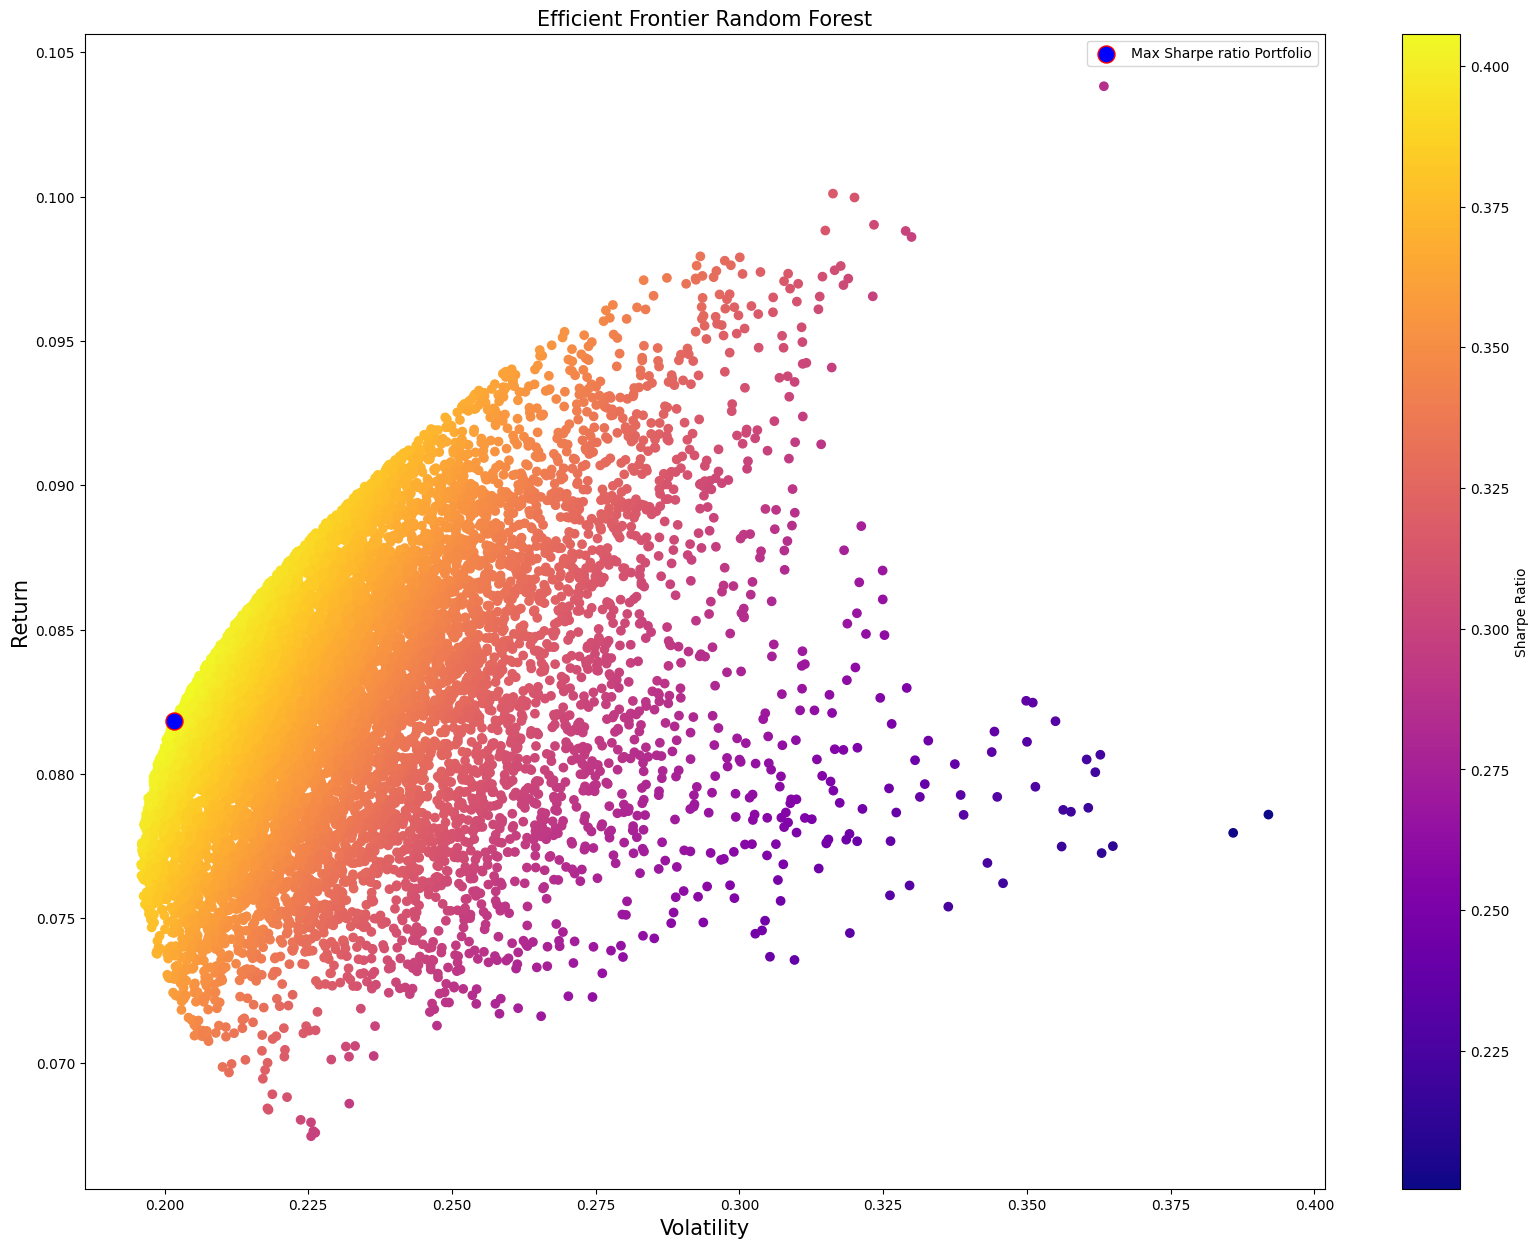

In [115]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility', fontsize=15)
plt.ylabel('Return', fontsize=15)
plt.title('Efficient Frontier Random Forest', fontsize=15)
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o', label='Max \
Sharpe ratio Portfolio')
plt.legend();
plt.savefig('forest_efficient_frontier.png')

33.27 % of PG should be bought.
25.86 % of KO should be bought.
34.77 % of MSFT should be bought.
6.09 % of JPM should be bought.

Markowitz optimal portfolio based on RandomForestRegressor annualized return is : 8.18% with volatility 0.20168503900130363


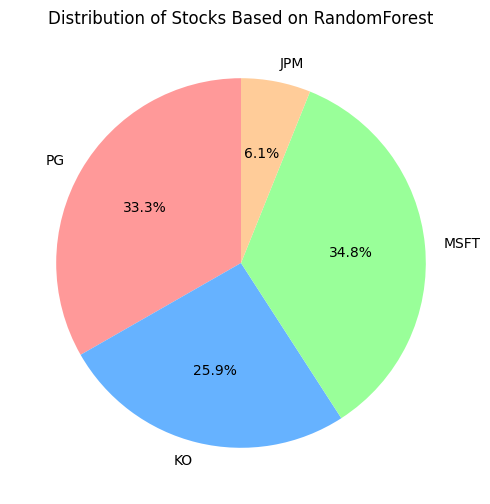

In [116]:
ticker_list = ['PG','KO','MSFT','JPM']
for weight, stocks in zip(port_weights[ind], ticker_list):
    print(f'{round(weight * 100, 2)} % of {stocks} should be bought.')
    

# best portfolio return
print(f'\nMarkowitz optimal portfolio based on RandomForestRegressor annualized return is : {round(max_sr_ret * 100, 2)}% with volatility \
{max_sr_vol}')



# Create a pie chart
forest_fig = plt.pie(port_weights[ind], labels=ticker_list, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'])
plt.title('Distribution of Stocks Based on RandomForest')
plt.savefig('forest_dist.png')

In [117]:
mse_arima = np.array([mse_jpm_arima, mse_ko_arima, mse_pg_arima, mse_msft_arıma])
mse_arima


array([0.07778014, 0.01021054, 0.00850865, 0.02706877])

In [118]:
rmse_arima = np.array([rmse_jpm_arima, rmse_ko_arima, rmse_pg_arima, rmse_msft_arıma])
rmse_arima

array([0.27889091, 0.10104723, 0.09224234, 0.1645259 ])

In [119]:
mse_forest = np.array([jpm_forest_mse, ko_forest_mse, pg_forest_mse, msft_forest_mse])
mse_forest

array([0.12616676, 0.09121286, 0.086183  , 0.19915005])

In [120]:
rmse_forest = np.array([jpm_forest_rsme, ko_forest_rsme, pg_forest_rsme, msft_forest_rsme])
rmse_forest

array([0.13937155, 0.09897357, 0.10488345, 0.24796585])

In [121]:
arima_stats = pd.DataFrame([mse_arima, rmse_arima])
arima_stats.columns = ["JPM","KO","PG","MSFT"]
arima_stats.index = ["MSE ARIMA", "RMSE ARIMA"]
arima_stats

JPM        KO        PG      MSFT
MSE ARIMA   0.077780  0.010211  0.008509  0.027069
RMSE ARIMA  0.278891  0.101047  0.092242  0.164526

In [122]:
forest_stats = pd.DataFrame([mse_forest, rmse_forest])
forest_stats.columns = ["JPM","KO","PG","MSFT"]
forest_stats.index = ["MSE FOREST", "RMSE FOREST"]
forest_stats

JPM        KO        PG      MSFT
MSE FOREST   0.126167  0.091213  0.086183  0.199150
RMSE FOREST  0.139372  0.098974  0.104883  0.247966

In [123]:
stats = pd.concat([arima_stats, forest_stats])
order = ["MSE ARIMA", "MSE FOREST", "RMSE ARIMA", "RMSE FOREST"]
stats = stats.loc[order]
stats


JPM        KO        PG      MSFT
MSE ARIMA    0.077780  0.010211  0.008509  0.027069
MSE FOREST   0.126167  0.091213  0.086183  0.199150
RMSE ARIMA   0.278891  0.101047  0.092242  0.164526
RMSE FOREST  0.139372  0.098974  0.104883  0.247966

In [124]:
forest_fc = pd.concat([pg_forest_fc, msft_forest_fc, ko_forest_fc, jpm_forest_fc], axis=1)
forest_fc.columns = ["PG", "MSFT", "KO", "JPM"]
forest_fc

PG      MSFT        KO       JPM
Date                                              
2002-01-07  3.064658  3.094661  2.523740  3.112767
2002-01-08  3.067646  3.121619  2.503407  3.067276
2002-01-09  3.060587  3.088475  2.487557  3.070376
2002-01-10  3.057016  3.118640  2.509836  3.118378
2002-01-11  3.060632  3.094636  2.519185  3.081738
...              ...       ...       ...       ...
2023-12-22  4.857037  5.416111  3.939739  4.817795
2023-12-26  4.857037  5.416111  3.941657  4.817795
2023-12-27  4.857037  5.416111  3.947146  4.817795
2023-12-28  4.857037  5.416111  3.948687  4.817795
2023-12-29  4.857037  5.416111  3.950258  4.817795

[5534 rows x 4 columns]

In [125]:
daily_portfolio_value = forest_fc.dot(port_weights[ind])
daily_portfolio_value

Date
2002-01-07    2.887256
2002-01-08    2.885380
2002-01-09    2.869137
2002-01-10    2.886422
2002-01-11    2.882436
                ...   
2023-12-22    4.680257
2023-12-26    4.680924
2023-12-27    4.682833
2023-12-28    4.683368
2023-12-29    4.683915
Length: 5534, dtype: float64

In [126]:
daily_returns = daily_portfolio_value.pct_change()

In [127]:
daily_returns

Date
2002-01-07         NaN
2002-01-08   -0.000650
2002-01-09   -0.005629
2002-01-10    0.006024
2002-01-11   -0.001381
                ...   
2023-12-22    0.000766
2023-12-26    0.000143
2023-12-27    0.000408
2023-12-28    0.000114
2023-12-29    0.000117
Length: 5534, dtype: float64

In [128]:
cumulative_returns_forest = (1 + daily_returns).cumprod()

In [129]:
cumulative_returns_forest

Date
2002-01-07         NaN
2002-01-08    0.999350
2002-01-09    0.993725
2002-01-10    0.999711
2002-01-11    0.998331
                ...   
2023-12-22    1.621005
2023-12-26    1.621236
2023-12-27    1.621897
2023-12-28    1.622083
2023-12-29    1.622272
Length: 5534, dtype: float64

In [130]:
total_return = cumulative_returns_forest.iloc[-1] - 1

In [131]:
total_return

0.6222720492432527

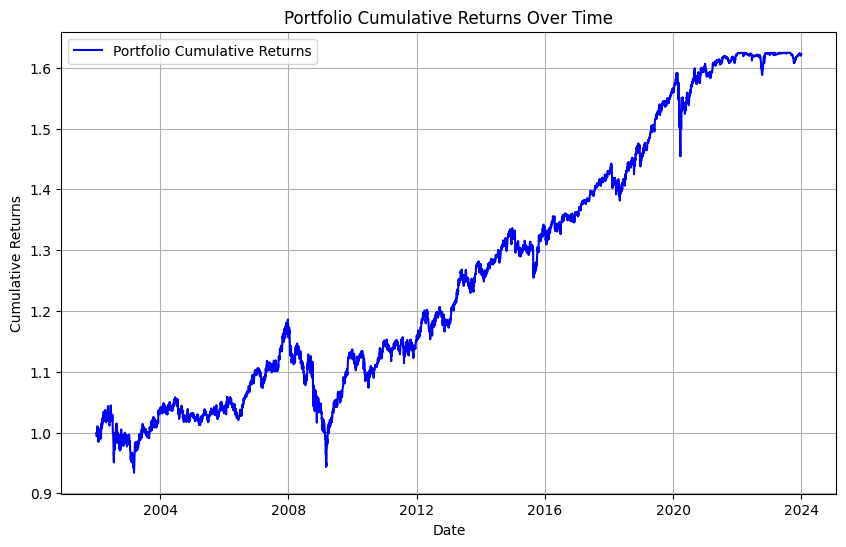

In [132]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_forest.index, cumulative_returns_forest, label='Portfolio Cumulative Returns', color='blue')
plt.title('Portfolio Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

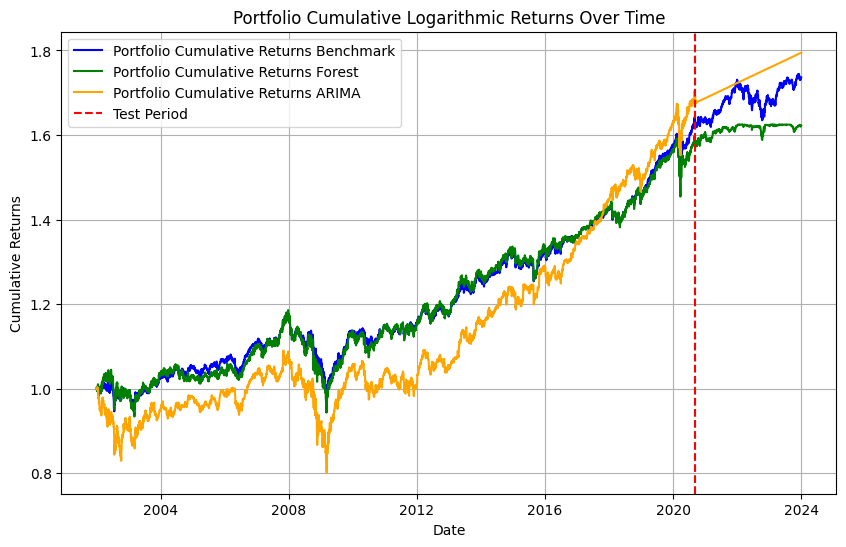

In [133]:

vertical_line_date = '2020-09-10'

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns_benchmark.index, cumulative_returns_benchmark, label='Portfolio Cumulative Returns Benchmark', color='blue')
plt.plot(cumulative_returns_forest.index, cumulative_returns_forest, label='Portfolio Cumulative Returns Forest', color='green')
plt.plot(cumulative_returns_arima.index, cumulative_returns_arima, label='Portfolio Cumulative Returns ARIMA', color = "orange")
vertical_line_numeric = pd.to_datetime(vertical_line_date)
plt.axvline(x=vertical_line_numeric, color='red', linestyle='--', label='Test Period')
plt.title('Portfolio Cumulative Logarithmic Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.savefig('cumulative_return.png')
plt.show()


In [134]:
portfolio_stat = pd.DataFrame([benchmark_portfolio_stat, arima_portfolio_stat, forest_portfolio_stat])
portfolio_stat.columns = ["Expected Return", "Expected Variance", "Sharpe Ratio"]
portfolio_stat.index = ["Markovitz Benchmark", "Arima Model", "Forest Model"]
portfolio_stat


Expected Return  Expected Variance  Sharpe Ratio
Markovitz Benchmark         0.100555           0.178752      0.562540
Arima Model                 0.110036           0.172645      0.637351
Forest Model                0.081829           0.201685      0.405725